In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)
# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

import seaborn as sns
from scipy.signal import savgol_filter

from ssa_calc import Satellite
from astropy.time import Time
import astropy.units as u

from scipy.optimize import curve_fit

2023-06-26 12:12:43.868800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 12:12:45.077704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-26 12:12:45.077809: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-26 12:12:45.077823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  1


In [2]:
def normalize_temperature(temps, limits=None):
    """
    Function to normalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be normalized.
    :param limits: Limits of the temperature data. If None, the limits are calculated from the data.

    :return: Normalized temperature data.
    """
    
    if limits is None:
        limits = np.array([np.min(temps), np.max(temps)])

    return (temps - limits[0]) / (limits[1] - limits[0])

def denormalize_temperature(temps, limits):
    """
    Function to denormalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be denormalized.
    :param limits: Limits of the temperature data.

    :return: Denormalized temperature data.
    """

    return temps * (limits[1] - limits[0]) + limits[0]

In [3]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, labels=None, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param bins: Number of bins to be used for the KDE.
    :param plot_kde: Boolean to plot the KDE.
    :param labels: Labels of the KDE plots.

    :return: kde, bin_centers
    """

    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the KDE values
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the bin centers
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])  # kernel density estimate function
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)  # bin centers
        kde[i, :] = kde_func(bin_centers[i])    # KDE values

    if plot_kde:
        plt.figure(figsize=(6, 5), tight_layout=True)
        for i in range(data.shape[1]):
            plt.plot(
                bin_centers[i],
                kde[i],
                color=plt_colors[i],
                label=labels[i] if labels is not None else None,
            )

        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density ($^\circ$C$^{-1}$)")
        if plt_title is None:
            plt_title = "Kernel density estimate of the errors"
        plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    return kde, bin_centers



def print_kde_stats(data, kde, bin_centers):
    """
    Function to print the mean, standard deviation and area under the KDE curve of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param kde: KDE values.
    :param bin_centers: Bin centers.

    :return: None
    """

    print("Battery:")
    print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
    print("Solar panel Yp:")
    print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
    print("Solar panel Ym:")
    print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
    print("Solar panel Xp:")
    print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
    print("Solar panel Xm:")
    print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
    print("MCU:")
    print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")


In [4]:
def plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=None,
    labels=None,
    colors=None,
    plt_scatter=None,
    linestyles=None,
    limits=None,
    plt_suptitle=None,
):
    """Plots the temperature values of the model.

    Parameters
    ----------
    theta_T_vals : list of numpy.ndarray
        List of theta_T values for each model.
    temp_vals : list of numpy.ndarray
        List of temperature values for each model.
    plt_titles : list of str, optional
        List of titles for each subplot, by default None
    labels : list of str, optional
        List of labels for each model, by default None
    colors : list of mpl colors, optional
        List of colors for each model, by default None
    plt_scatter : list of bool, optional
        List of bools to indicate if the model should be plotted as a scatter plot, by default None
    linestyles : list of str, optional
        List of linestyles for each model, by default None
    limits : list of list of float, optional
        List of limits for each axis, by default None
    plt_suptitle : str, optional
        Title for the figure, by default None
    """

    plt_rows = 2
    plt_cols = 3

    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols * 5, plt_rows * 5))

    for i in range(plt_rows):
        for j in range(plt_cols):
            for k in range(len(theta_T_vals)):
                if plt_scatter[k]:
                    ax[i, j].scatter(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        s=2,
                    )
                else:
                    ax[i, j].plot(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        linestyle=linestyles[k] if linestyles is not None else "-",
                    )

            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * plt_cols + j] if plt_titles is not None else None)
            ax[i, j].legend(fontsize=8)
            if limits is not None:
                ax[i, j].set_xlim(limits[0])
                ax[i, j].set_ylim(limits[1])

            ax[i, j].grid()

    if plt_suptitle is not None:
        fig.suptitle(plt_suptitle, fontsize=12)

    return fig, ax

In [5]:
class Model:
    """
    Class to hold the model and its training and testing data.

    :param train_x: Training input data.
    :param train_y: Training output data.
    :param test_x: Testing input data.
    :param test_y: Testing output data.
    :param name: Name of the model.
    :param model: Tensorflow model.
    :param run_device: Device to run the model on.
    :param history: History of the model training.
    """

    def __init__(self, train_x, train_y, test_x, test_y, name=None):
        """
        Initialize the model class.
        :param train_x: Training input data.
        :param train_y: Training output data.
        :param test_x: Testing input data.
        :param test_y: Testing output data.
        :param name: Name of the model.

        :return: None
        """

        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.name = name
        self.model = None
        self.run_device = None
        self.history = None


    def create_model(self, layers, optimizer, loss, metrics, input_shape, output_shape):
        """
        Create the model.
        :param layers: List of layers stored as dictionaries with the following keys: type, units, activation.
        :param optimizer: Optimizer function to use for trining.
        :param loss: Loss function to use for training.
        :param metrics: Metrics to use for training.
        :param input_shape: Shape of the input data.
        :param output_shape: Shape of the output data.

        :return: None
        """

        self.model = tf.keras.Sequential(name=self.name)    # create the model
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))   # add the input layer
        self.run_device = "/GPU:0"  # set the device to run the model on

        # Add the layers to the model
        for i, layer in enumerate(layers):
            if layer.get("type") == "LSTM":
                if i < len(layers) - 1:
                    if layers[i + 1].get("type") == "LSTM":
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=True,
                            )
                        )
                    else:
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=False,
                            )
                        )
                else:
                    self.model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
                if layer.get("activation") == "relu":
                    self.run_device = "/CPU:0"  # if the model uses a ReLU activation function, run it on the CPU
            elif layer.get("type") == "Dense":
                self.model.add(
                    tf.keras.layers.Dense(
                        layer.get("units"), activation=layer.get("activation"),
                    )
                )
            else:
                raise ValueError("Invalid layer type")  # raise an error if the layer type is invalid

        self.model.add(tf.keras.layers.Dense(output_shape, activation="linear"))    # add the output layer

        # Compile the model
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metrics],
        )

    
    def train_model(self, epochs, callbacks=None, batch_size=100, plot_train_history=True, verbose=True, monitor_val_loss=True):
        """
        Function to train the model.
        :param epochs: Number of epochs to train the model for.
        :param callbacks: Callbacks to use during training.

        :return: None
        """
        # if self.test_x is None or self.test_y is None:
        #     monitor_val_loss = False
        # else:
        #     monitor_val_loss = True
        # Train the model
        with tf.device(self.run_device):
            if monitor_val_loss:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(self.test_x, self.test_y),
                    callbacks=[callbacks],
                    verbose=verbose,
                )
            else:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                )

        # Plot the training history
        if plot_train_history:
            plt.figure(figsize=(5, 5))
            plt.plot(
                np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                self.history.history["loss"],
                color=plt_colors[0],
                label="Training Loss",
            )
            if monitor_val_loss:
                plt.plot(
                    np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                    self.history.history["val_loss"],
                    color=plt_colors[1],
                    label="Validation Loss",
                )
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(self.name)
            plt.legend()
            plt.grid()
            plt.show()

In [6]:
# Loading the data
telem_path = r"../../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2023-02-01.h5"
telem_raw_df = pd.read_hdf(
    telem_path,
    "telem",
)

telem_raw_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2022-01-18 17:12:17.000  2.459598e+06   32.895989  0.349273   220.506984   
1  2022-01-18 18:41:24.000  2.459598e+06   32.900397  0.349014   197.714357   
2  2022-01-18 18:43:24.000  2.459598e+06   32.901143  0.349090   205.275916   
3  2022-01-18 18:44:24.000  2.459598e+06   32.901391  0.349131   209.056697   
4  2022-01-18 18:45:24.000  2.459598e+06   32.901552  0.349173   212.837490   

   theta_T (deg)  battery GG temperature (deg C)  \
0     337.637846                            -4.2   
1     314.891798                            -0.7   
2     322.439748                            -1.9   
3     326.213181                            -2.4   
4     329.986271                            -3.0   

   battery TMP20 temperature (deg C)  solar panel Yp temperature (deg C)  \
0                               -3.2                               -24.7   
1                                0.8                               -18.5   
2                                0.0                               -20.9   
3                               -0.2                               -21.9   
4                               -1.3                               -23.0   

   solar panel Ym temperature (deg C)  solar panel Xp temperature (deg C)  \
0                               -26.4                               -25.0   
1                               -20.7                               -18.6   
2                               -22.7                               -20.8   
3                               -23.8                               -22.1   
4                               -24.9                               -23.2   

   solar panel Xm temperature (deg C)  MCU temperature (deg C)  
0                               -23.4                    -12.2  
1                               -17.8                     -7.4  
2                               -19.9                     -8.9  
3                               -20.9                     -9.8  
4                               -21.9                    -11.2

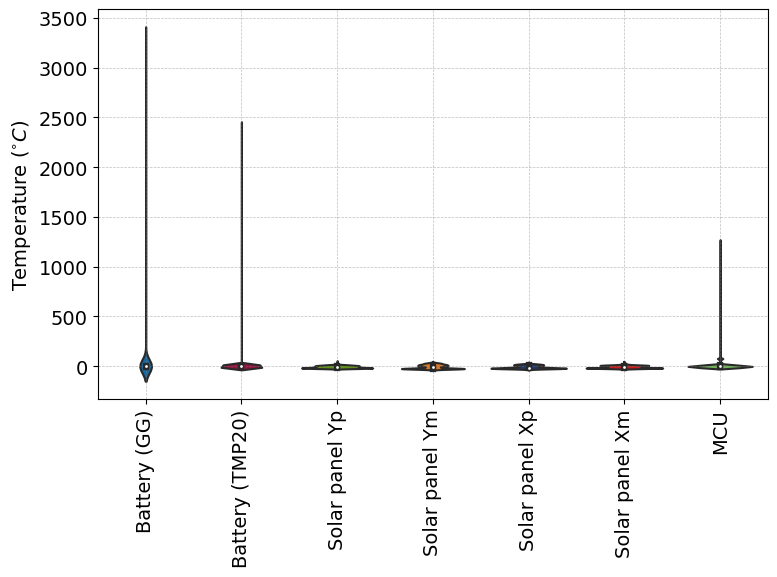

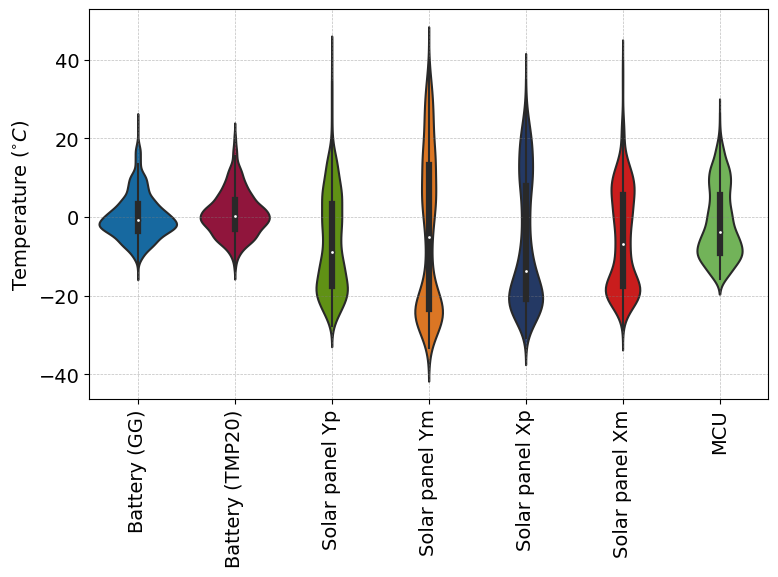

In [12]:
# Plotting the temperature data in a violin plot:
plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
ax = sns.violinplot(data=telem_raw_df.iloc[:, 6:], palette=plt_colors[0:7])
ax.set_ylabel("Temperature $(^{\circ}C)$")
_ = ax.set_xticklabels(["Battery (GG)", "Battery (TMP20)", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"], rotation=90)
ax.grid()
fig.savefig(f"../../report/images/chapter-3/delfi-pq-threshold-before.pdf")
plt.show()

# Removing obvious anomalies:
telem_df = telem_raw_df.copy(deep=True)
for i, row in telem_df.iterrows():
    for j, item in row.iloc[6:].items():
        if not -40 < item < 70:
            telem_df.loc[i, j] = np.nan
            
telem_df = telem_df.dropna(how="any")
telem_df = telem_df.iloc[1:, :]

# Plotting the temperature data in a violin plot:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
ax = sns.violinplot(data=telem_df.iloc[:, 6:], palette=plt_colors[0:7])
ax.set_ylabel("Temperature $(^{\circ}C)$")
_ = ax.set_xticklabels(["Battery (GG)", "Battery (TMP20)", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"], rotation=90)
ax.grid()
fig.savefig(f"../../report/images/chapter-3/delfi-pq-threshold-after.pdf")
plt.show()

In [13]:
def hampel_filter(data):
    data = data.copy()
    median = np.median(data)
    MAD = np.median(np.abs(data - median))
    HI = (data - median) / (1.4826 * MAD)
    data[HI > 3] = np.nan
    
    return data

In [14]:
illumination_data = np.load(r"./illumination_data.npy")
illumination_data = illumination_data[1:]


theta_T_window = 5
min_data = 7
telem_processed_df = telem_df.copy(deep=True).reset_index(drop=True)
theta_T_bins = np.arange(0, 360, theta_T_window)
theta_T = telem_processed_df["theta_T (deg)"].to_numpy()

for i in range(7):
    raw_temps = telem_processed_df.iloc[:, 6+i].to_numpy()
    cleaned_temps = raw_temps.copy()
    for theta_T_bin in theta_T_bins:
        idxs = np.where((theta_T >= theta_T_bin) & (theta_T < theta_T_bin + theta_T_window))[0]
        temps = raw_temps[idxs]
        if temps.shape[0] < min_data:
            temps[:] = np.nan
        else:
            temps = hampel_filter(temps)
        cleaned_temps[idxs] = temps
        
    telem_processed_df.iloc[:, 6+i] = cleaned_temps
    
print(telem_processed_df.shape)
print(illumination_data.shape)
# Get indexes of rows containing NaNs
nan_idxs = telem_processed_df.index[telem_processed_df.isna().any(axis=1)].tolist()
# Drop rows containing NaNs and the corresponding illumination data
telem_processed_df = telem_processed_df.dropna(how="any")
illumination_data = np.delete(illumination_data, nan_idxs, axis=0)

print(telem_processed_df.shape)
print(illumination_data.shape)
    

(2486, 13)
(2486, 120)
(2106, 13)
(2106, 120)


Text(0, 0.5, 'Temperature ($^{\\circ}$C)')

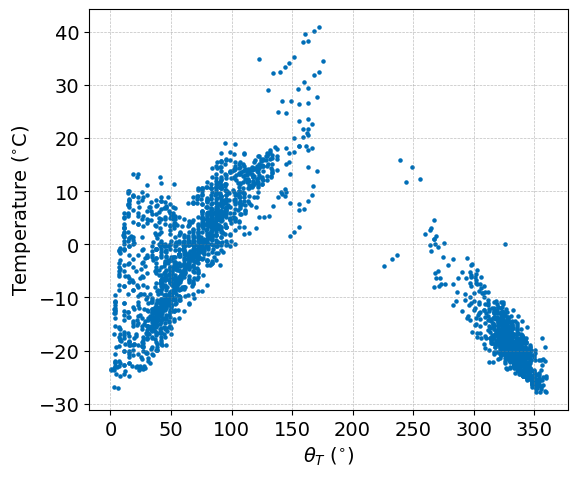

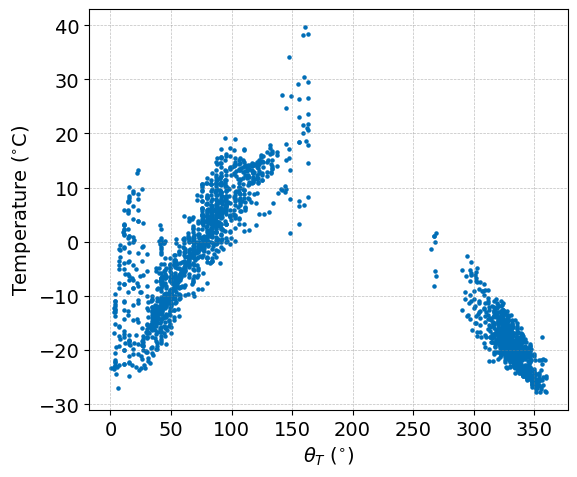

In [15]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(telem_df["theta_T (deg)"], telem_df["solar panel Yp temperature (deg C)"], s=5, color=plt_colors[0])
ax.grid()
ax.set_xlabel(r"$\theta_T$ ($^{\circ}$)")
ax.set_ylabel("Temperature ($^{\circ}$C)")
# fig.savefig(f"../../report/images/chapter-3/delfi-pq-yp-hampel-before.pdf")

fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(telem_processed_df["theta_T (deg)"], telem_processed_df["solar panel Yp temperature (deg C)"], s=5, color=plt_colors[0])
ax.grid()
ax.set_xlabel(r"$\theta_T$ ($^{\circ}$)")
ax.set_ylabel("Temperature ($^{\circ}$C)")
# fig.savefig(f"../../report/images/chapter-3/delfi-pq-yp-hampel-after.pdf")

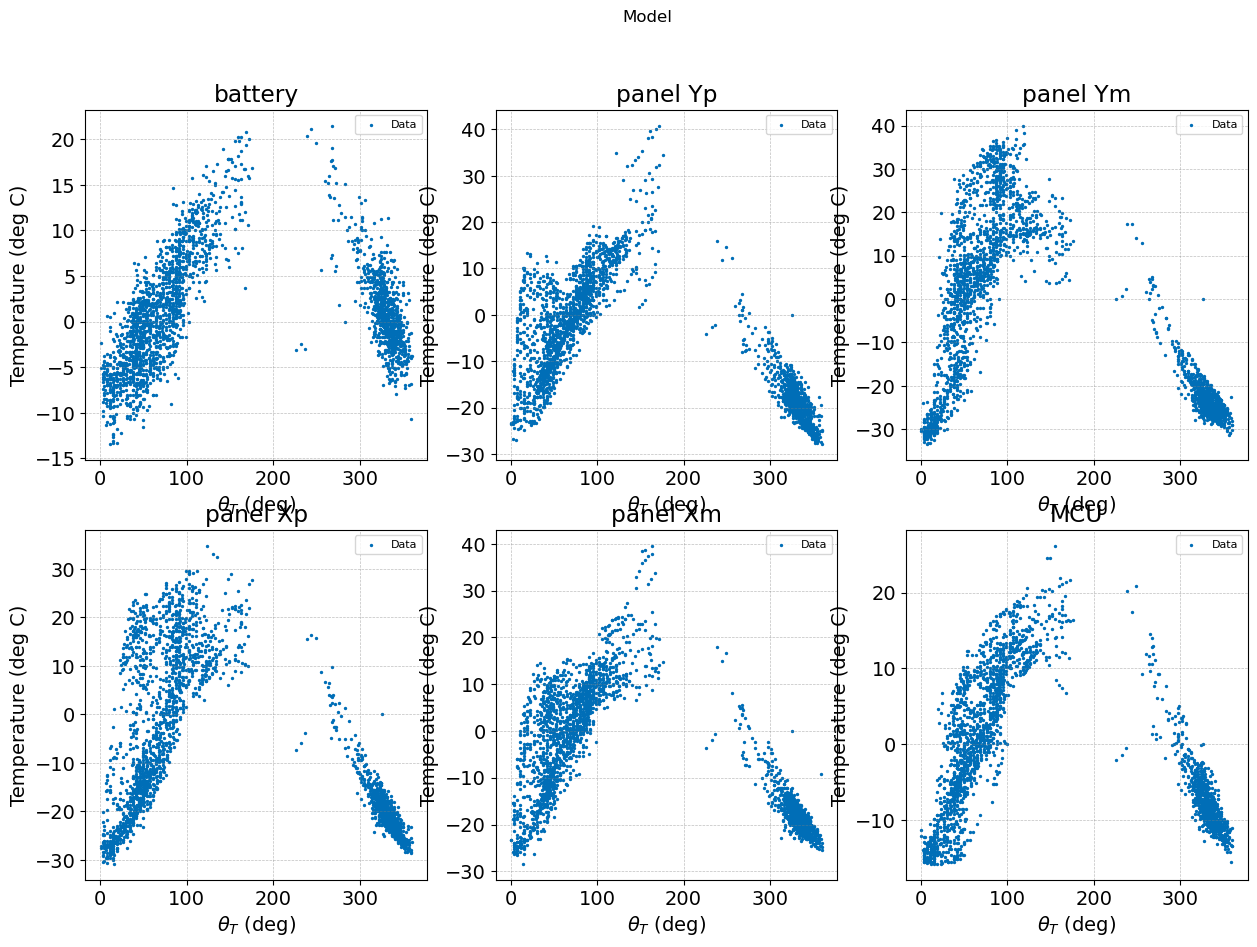

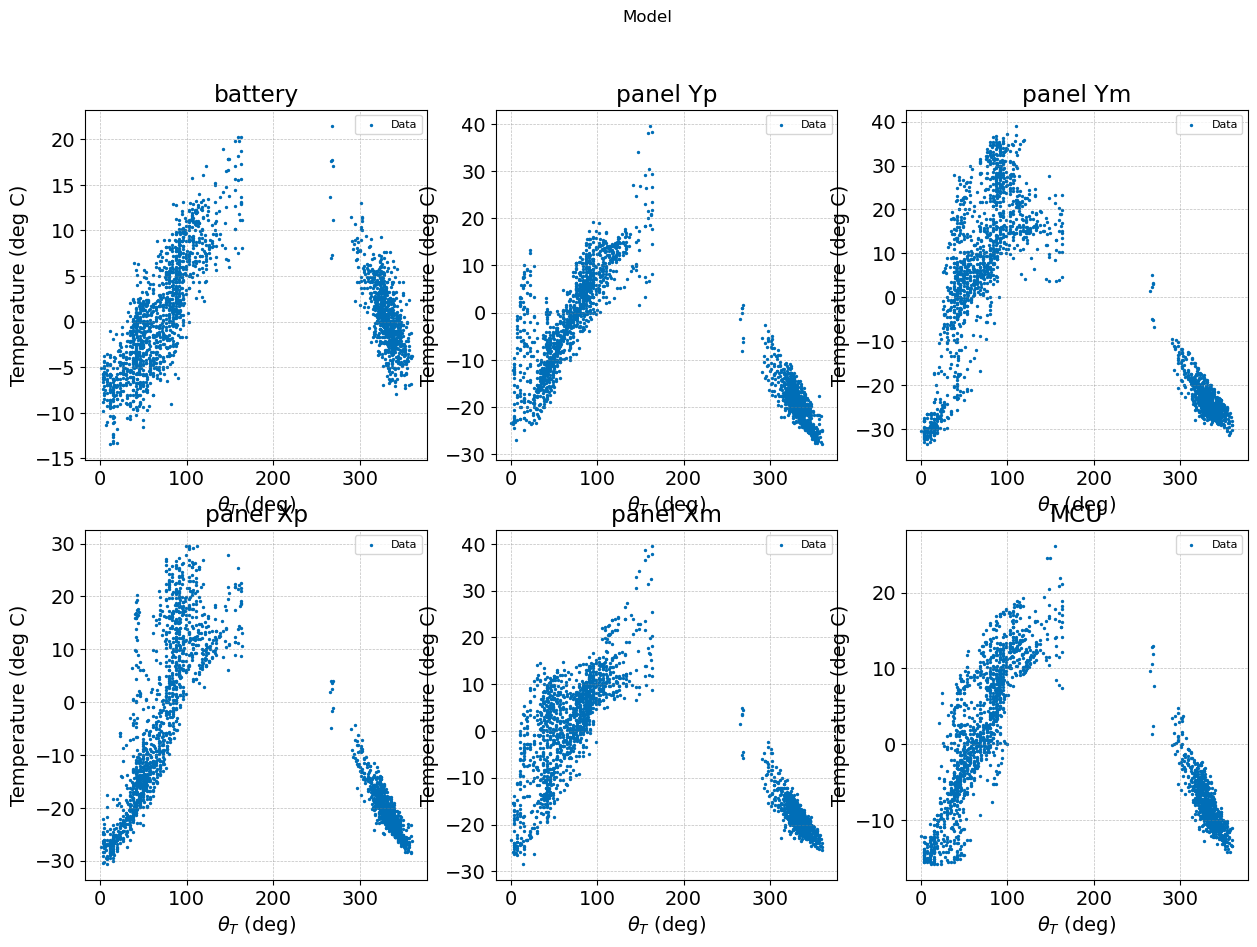

In [16]:
theta_T_vals = [telem_df["theta_T (deg)"], telem_processed_df["theta_T (deg)"]]
temp_vals = [telem_df.iloc[:, -6:].to_numpy(), telem_processed_df.iloc[:, -6:].to_numpy()]

plt_titles = ["battery", "panel Yp", "panel Ym", "panel Xp", "panel Xm", "MCU"]
fig, ax = plot_model(theta_T_vals[:1], temp_vals[:1], plt_suptitle="Model", plt_scatter=[True], plt_titles=plt_titles, labels=["Data"])
fig, ax = plot_model(theta_T_vals[1:], temp_vals[1:], plt_suptitle="Model", plt_scatter=[True], plt_titles=plt_titles, labels=["Data", "Cleaned data"])

# Curve fit for full data

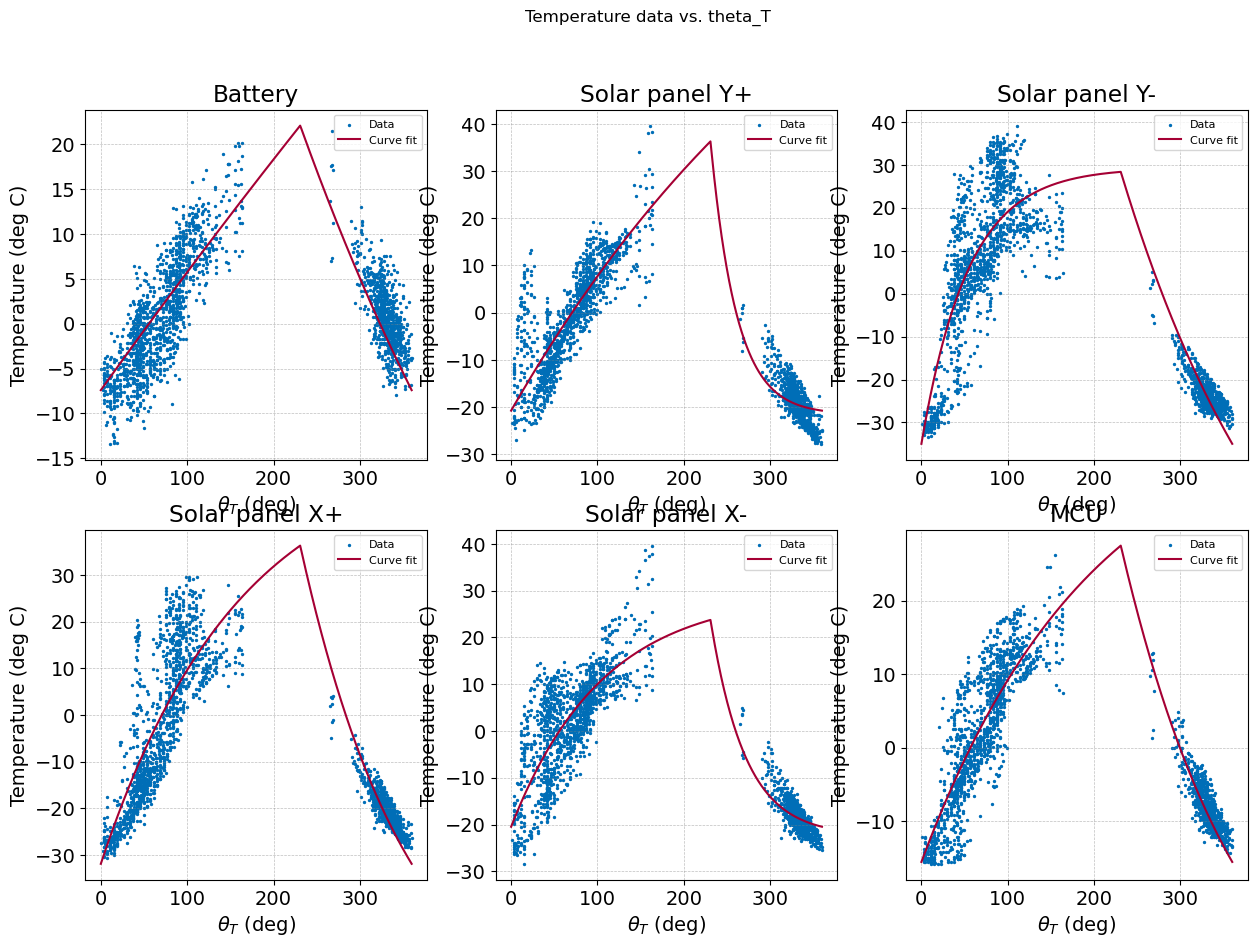

In [17]:
fe_mean = np.mean(telem_df["fe"])   # Mean fe for the data
theta_E = 360 * (1 - fe_mean)       # Mean theta_E for the data

def fit_function(theta_T, T_sat_rising, r_rising, T_0, dT_0_falling):
    """
    Function to fit to the temperature data.
    :param theta_T: Array of theta_T values
    :param T_sat_rising: Saturation temperature of the heating phase
    :param r_rising: Rate of temperature rise during heating phase
    :param T_0: Temperature at theta_T = 0
    :param dT_0_falling: delta T between T_0 and saturation temperature of cooling phase
    """
    T_E = T_sat_rising * (1 - np.exp(-r_rising * theta_E)) + T_0    # Temperature at the beginning of ecllipse

    T_sat_falling = T_0 - dT_0_falling  # Saturation cooling temperature at theta_T = inf

    # Determining rate of falling temperature to satisfy T_begin = T_end at theta_E = 0 and theta_E = 360
    r_falling = -np.log(dT_0_falling / (T_E - T_sat_falling)) / (360 - theta_E)

    return_array = np.empty(shape=theta_T.shape, dtype=np.float64)

    for i, theta_T_i in enumerate(theta_T):
        if theta_T_i < theta_E:
            return_array[i] = T_sat_rising * (1 - np.exp(-r_rising * theta_T_i)) + T_0
        else:
            return_array[i] = (T_E - T_sat_falling) * np.exp(-r_falling * (theta_T_i - theta_E)) + T_sat_falling

    return return_array

fit_params = np.zeros(shape=(6, 4), dtype=np.float64)
fit_errors = np.zeros(shape=(6, 4), dtype=np.float64)

for i in range(6):
    popt, pcov = curve_fit(
        fit_function,
        telem_processed_df["theta_T (deg)"].to_numpy()[:int(0.8*telem_processed_df.shape[0])],
        telem_processed_df.iloc[:, -6+i].to_numpy()[:int(0.8*telem_processed_df.shape[0])] + 273.15,
        p0=[25, 0.01, 300, 10],
        bounds=([5, 0, 200, 0.1], [300, 1, 350, 75]),
    )
    
    fit_params[i] = popt
    fit_errors[i] = np.sqrt(np.diag(pcov))
    

# Plotting the curve fit:
theta_T_fit = np.linspace(0, 360, 500)
temp_fit = np.empty(shape=(theta_T_fit.shape[0], 6), dtype=np.float64)

for i in range(6):
    temp_fit[:, i] = fit_function(theta_T_fit, *fit_params[i]) - 273.15

_ = plot_model(
    [telem_processed_df["theta_T (deg)"].to_numpy(), theta_T_fit],
    [telem_processed_df.iloc[:, -6:].to_numpy(), temp_fit],
    plt_titles=[
        "Battery",
        "Solar panel Y+",
        "Solar panel Y-",
        "Solar panel X+",
        "Solar panel X-",
        "MCU",
    ],
    labels=["Data", "Curve fit"],
    plt_scatter=[True, False],
    plt_suptitle="Temperature data vs. theta_T",
)

In [80]:
actual = telem_processed_df.iloc[:, -6:].to_numpy()[int(0.8*telem_processed_df.shape[0]):]
predicted = np.zeros(shape=actual.shape, dtype=np.float64)

for i in range(6):
    predicted[:, i] = fit_function(telem_processed_df["theta_T (deg)"].to_numpy()[int(0.8*telem_processed_df.shape[0]):], *fit_params[i]) - 273.15
    
errors = actual-predicted

0.8657048117999014
5.96089480945206


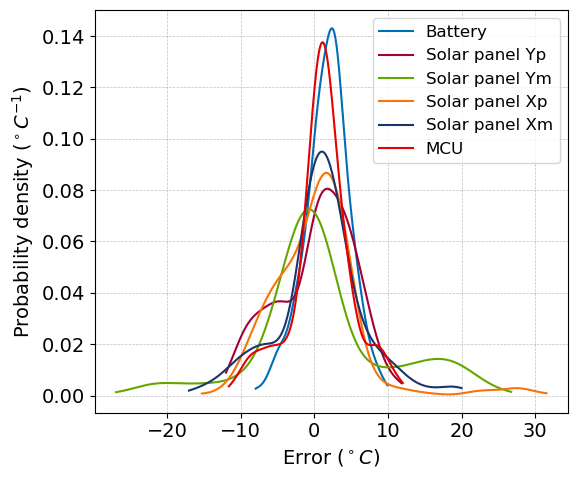

In [83]:
kde_vals, bins = kde(
    errors,
    plot_kde=False,
)
labels = ["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"]
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
for i in range(6):
    ax.plot(bins[i], kde_vals[i], label=labels[i],  color=plt_colors[i])
ax.set_xlabel(r"Error ($^\circ C$)")
ax.set_ylabel(r"Probability density ($^\circ C^{-1}$)")
ax.grid()
ax.legend(fontsize=12)

print(np.nanmean(errors))
print(np.nanstd(errors))
fig.savefig("../../report/images/chapter-5/delfi-pq-curve-fit-error-kde.pdf")

In [22]:
# fit_params[:, 0] -= 273.15
fit_params[:, 2] -= 273.15

In [26]:
print("Battery:")
print(f"{fit_params[0, 0]:.2f} & {fit_params[0, 1]} & {fit_params[0, 2]:.2f} & {fit_params[0, 3]:.2f} \\\\")
print("Solar panel Y+:")
print(f"{fit_params[1, 0]:.2f} & {fit_params[1, 1]} & {fit_params[1, 2]:.2f} & {fit_params[1, 3]:.2f} \\\\")
print("Solar panel Y-:")
print(f"{fit_params[2, 0]:.2f} & {fit_params[2, 1]} & {fit_params[2, 2]:.2f} & {fit_params[2, 3]:.2f} \\\\")
print("Solar panel X+:")
print(f"{fit_params[3, 0]:.2f} & {fit_params[3, 1]} & {fit_params[3, 2]:.2f} & {fit_params[3, 3]:.2f} \\\\")
print("Solar panel X-:")
print(f"{fit_params[4, 0]:.2f} & {fit_params[4, 1]} & {fit_params[4, 2]:.2f} & {fit_params[4, 3]:.2f} \\\\")
print("MCU:")
print(f"{fit_params[5, 0]:.2f} & {fit_params[5, 1]} & {fit_params[5, 2]:.2f} & {fit_params[5, 3]:.2f} \\\\")

Battery:
300.00 & 0.0004407431843702283 & -6.93 & 75.00 \\
Solar panel Y+:
192.73 & 0.0016133575432383262 & -21.35 & 2.55 \\
Solar panel Y-:
62.20 & 0.019435882324599273 & -34.09 & 44.97 \\
Solar panel X+:
89.94 & 0.0060350979749186845 & -31.41 & 37.94 \\
Solar panel X-:
48.77 & 0.01020244579020137 & -21.22 & 4.61 \\
MCU:
58.72 & 0.005518980570950088 & -15.64 & 41.52 \\


In [39]:
max_size = 45   # days
batches = []

start_time = telem_processed_df["time (jd)"][0]
start_idx = 0
for i, row in telem_processed_df.iterrows():
    if row["time (jd)"] - start_time > max_size:
        batches.append(telem_processed_df.loc[start_idx:i-1].copy())
        start_time = row["time (jd)"]
        start_idx = i
        
batches.append(telem_processed_df.loc[start_idx:].copy())

print(f"number of batches: {len(batches)}")

number of batches: 9


In [40]:
# Fitting on batches
fit_params_batches = np.zeros(shape=(len(batches), 6, 4), dtype=np.float64)
fit_errors_batches = np.zeros(shape=(len(batches), 6, 4), dtype=np.float64)
bounds = ([0, 0, 200, 0.1], [150, 1, 350, 75])
for i, batch in enumerate(batches):
    for j in range(6):
        popt, pcov = curve_fit(
            fit_function,
            batch["theta_T (deg)"].to_numpy(),
            batch.iloc[:, -6+j].to_numpy() + 273.15,
            p0=[25, 0.01, 300, 10],
            bounds=bounds,
        )
        
        
        fit_errors_batches[i, j] = np.sqrt(np.diag(pcov))
        # # Check if any of the parameters are at the bounds
        # for k, param in enumerate(popt):
        #     if param - bounds[0][k] < 0.01 or bounds[1][k] - param < 0.01:
        #         popt[k] = np.nan
                
        fit_params_batches[i, j] = popt

Text(0.5, 0.98, 'T_sat_rising vs. batch number')

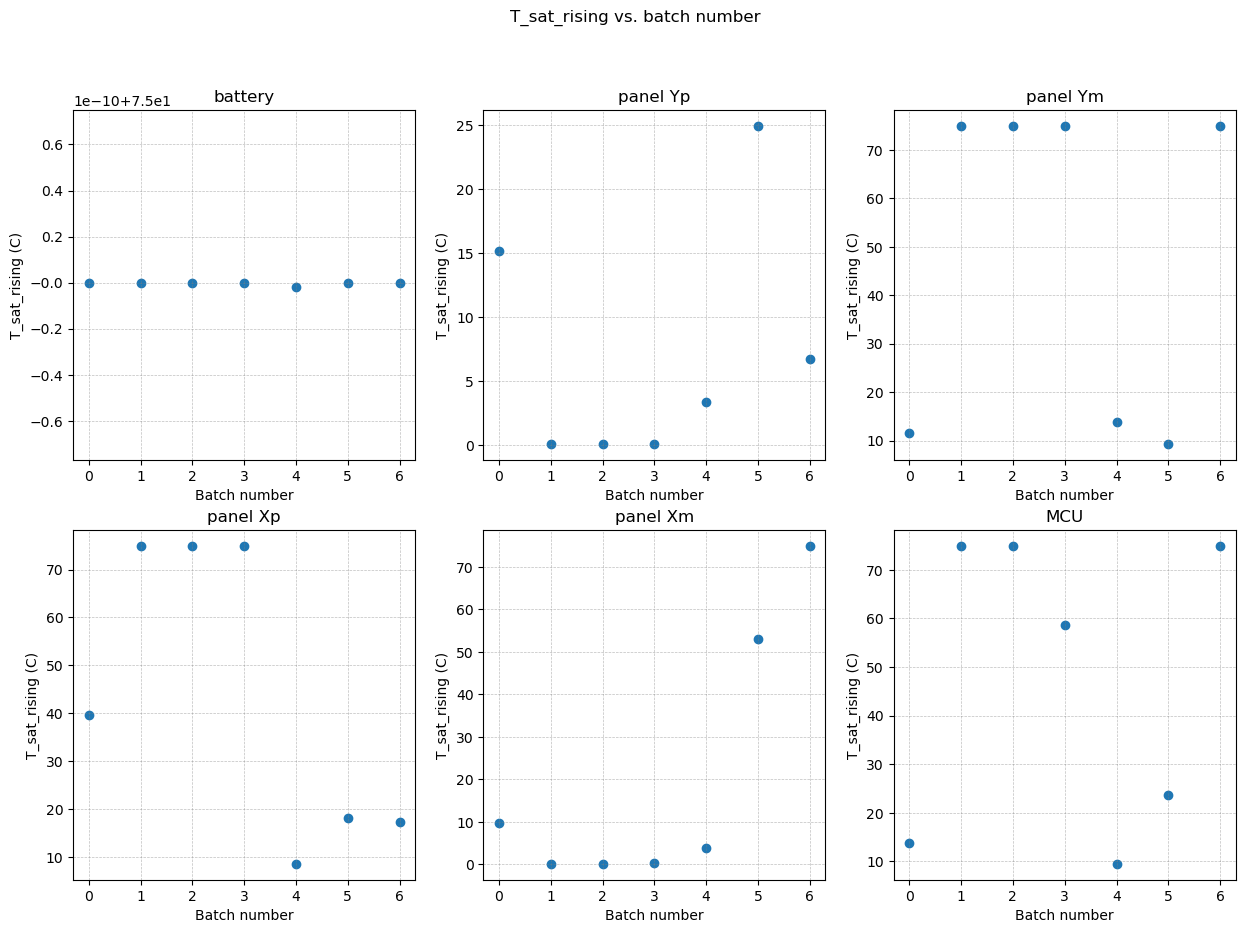

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
for i in range(6):
    ax[i].scatter(np.arange(len(batches)), fit_params_batches[:, i, 3], label="T_sat_rising")
    ax[i].set_title(plt_titles[i])
    ax[i].set_xlabel("Batch number")
    ax[i].set_ylabel("T_sat_rising (C)")
    ax[i].grid()
fig.suptitle("T_sat_rising vs. batch number")

In [32]:
fit_params_batches.shape

(7, 6, 4)

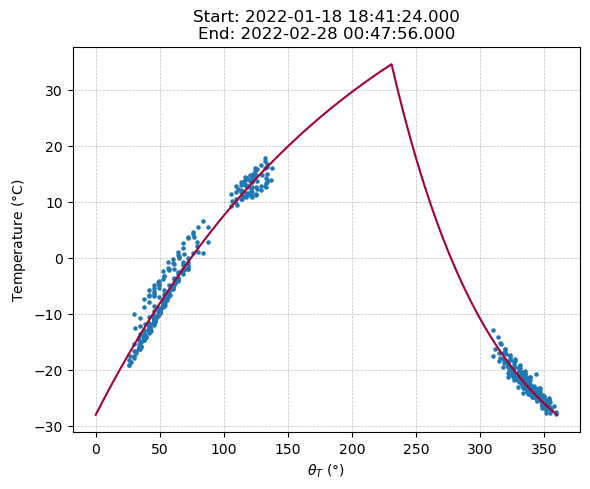

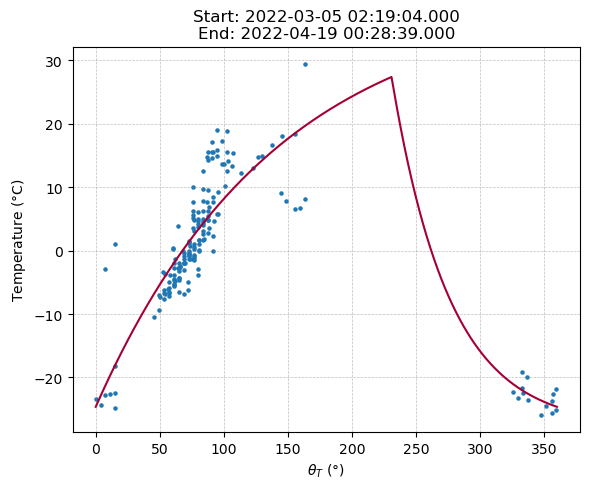

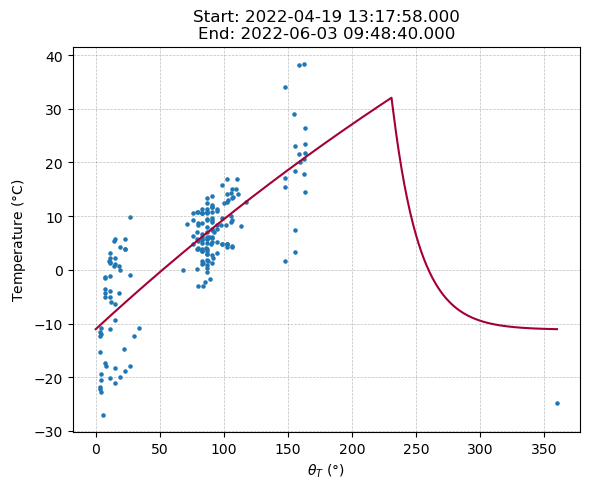

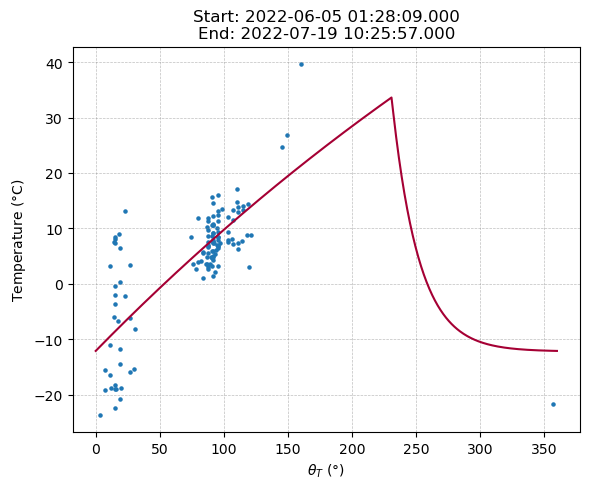

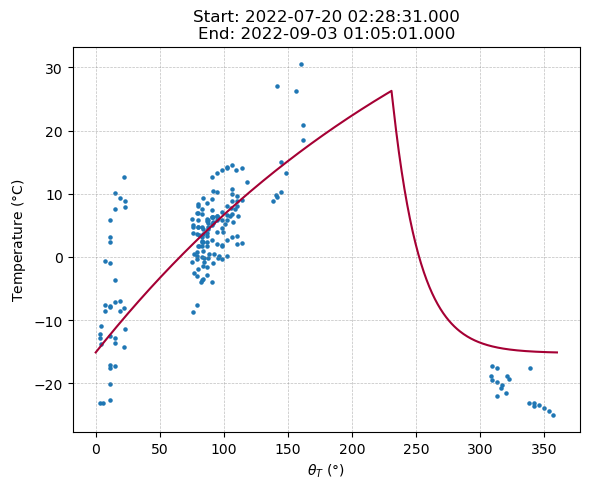

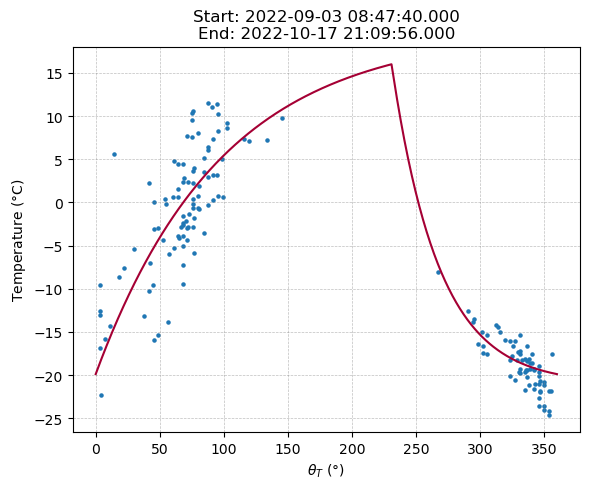

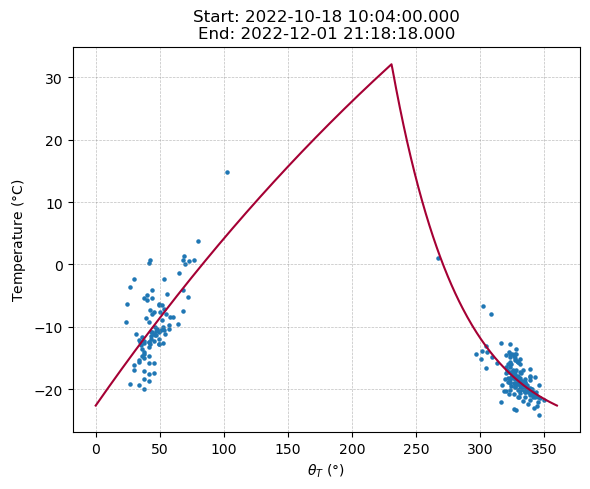

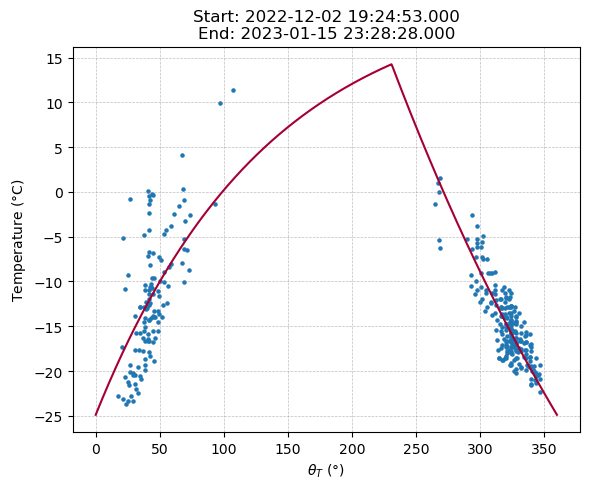

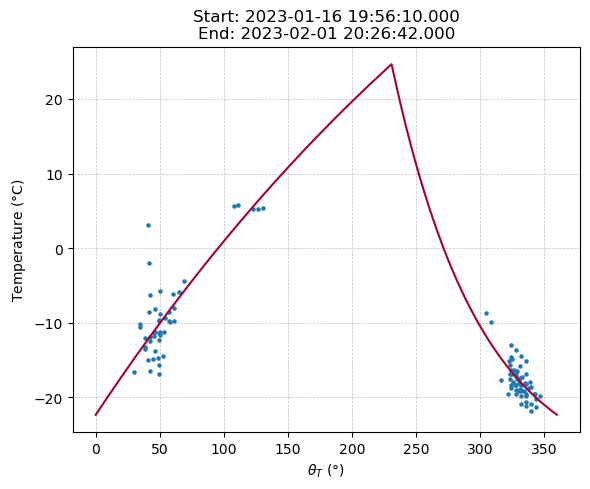

In [47]:
# Plotting curve fit on batches for battery temperature
plot_idx = 1
for i in range(fit_params_batches.shape[0]):
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.scatter(batches[i]["theta_T (deg)"], batches[i].iloc[:, -6+plot_idx].to_numpy(), s=5)
    ax.plot(theta_T_fit, fit_function(theta_T_fit, *fit_params_batches[i, plot_idx]) - 273.15, color=plt_colors[1])
    ax.grid()
    ax.set_xlabel(r"$\theta_T$ ($\degree$)")
    ax.set_ylabel(r"Temperature ($\degree$C)")
    ax.set_title(f"Start: {batches[i]['time (utc)'].to_numpy()[0]}\nEnd: {batches[i]['time (utc)'].to_numpy()[-1]}")

In [20]:
# Curve fit model:
def curve_fit_model(theta_T, fit_params):
    """
    Model that uses the curve fit as the base model.
    :param theta_T: Array of theta_T values

    :return: Array of temperature values
    """
    temp = np.empty(shape=(theta_T.shape[0], 6), dtype=np.float64)

    for i in range(6):
        temp[:, i] = fit_function(theta_T, *fit_params[i]) - 273.15

    return temp

# Purely curve-fit model

In [21]:
# Initializing delfi-pq satellite
POS_INTERP = r"../../orbit-propagation/interpolators/delfi-pq-pos-interpolator-2022-01-18-to-2023-02-05.pkl"
VEL_INTERP = r"../../orbit-propagation/interpolators/delfi-pq-vel-interpolator-2022-01-18-to-2023-02-05.pkl"

delfi_pq = Satellite(POS_INTERP, VEL_INTERP)

Loading interpolators from pickle files...
Interpolators loaded.


In [22]:
def window_data_base_illumination(df, window_size, illumination_data):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["battery temp"],
        ["solar panel Yp temp"],
        ["solar panel Ym temp"],
        ["solar panel Xp temp"],
        ["solar panel Xm temp"],
        ["MCU temp"]
    ))

    window_df = pd.DataFrame(columns=columns)

    with alive_bar(len(df), theme="classic", force_tty=True) as bar:
        for i, row in df.iterrows():
            window_df.loc[i, "theta_T"] = np.float64(df.loc[i, "theta_T (deg)"])
            window_df.loc[i, "illumination 0":"illumination "+str(window_size-1)] = illumination_data[i, -window_size:]
            window_df.loc[i, "battery temp"] = df.loc[i, "battery TMP20 temperature (deg C)"]
            window_df.loc[i, "solar panel Yp temp"] = df.loc[i, "solar panel Yp temperature (deg C)"]
            window_df.loc[i, "solar panel Ym temp"] = df.loc[i, "solar panel Ym temperature (deg C)"]
            window_df.loc[i, "solar panel Xp temp"] = df.loc[i, "solar panel Xp temperature (deg C)"]
            window_df.loc[i, "solar panel Xm temp"] = df.loc[i, "solar panel Xm temperature (deg C)"]
            window_df.loc[i, "MCU temp"] = df.loc[i, "MCU temperature (deg C)"]
            bar()
            
    x = window_df.iloc[:, 1:-6].to_numpy()
    y = window_df.iloc[:, -6:].to_numpy()

    return window_df, x.reshape(-1, window_size, 1), y

In [23]:
telem_processed_df = telem_processed_df.reset_index(drop=True)
train_df = telem_processed_df.iloc[:int(0.8*len(telem_processed_df)), :].copy()
test_df = telem_processed_df.iloc[int(0.8*len(telem_processed_df)):, :].copy()

norm_limits = [np.min(train_df.iloc[:, -6:].to_numpy()), np.max(train_df.iloc[:, -6:].to_numpy())]
train_norm_df = train_df.copy(deep=True)
train_norm_df.iloc[:, -7:] = normalize_temperature(train_norm_df.iloc[:, -7:].to_numpy(), norm_limits)
test_norm_df = test_df.copy(deep=True)
test_norm_df.iloc[:, -7:] = normalize_temperature(test_norm_df.iloc[:, -7:].to_numpy(), norm_limits)

base_window_size = 96
base_train_window_df, base_train_x, base_train_y = window_data_base_illumination(train_norm_df, base_window_size, illumination_data)
base_test_window_df, base_test_x, base_test_y = window_data_base_illumination(test_norm_df, base_window_size, illumination_data)

[========================================] 1684/1684 [100%] in 5.6s (301.06/s)                                          
[========================================] 422/422 [100%] in 0.8s (523.69/s)                                            


In [24]:
# Creating illumination data for a full orbit
start_time = Time("2022-01-27 18:33:00", format="iso", scale="utc")
end_time = start_time + 94 * u.min

start = delfi_pq.calc_beta_fe_theta(start_time)
end = delfi_pq.calc_beta_fe_theta(end_time)

print(start[3].to(u.deg))
print(end[3].to(u.deg))

# Artificial orbit
artificial_df = pd.DataFrame(columns=base_train_window_df.columns, index=np.arange(15*96))
time = start_time
with alive_bar(12*95, theme='classic', force_tty=True) as bar:
    for i in range(12*96):
        beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(time)
        artificial_df.iloc[i, 0] = theta_T.to(u.deg).value
        for j in range(96):
            calc_time = time - (96 - j) * u.min
            beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(calc_time)
            if theta_T.value < 2 * np.pi * (1 - fe.value):
                artificial_df.loc[i, "illumination " + str(j)] = 1
            else:
                artificial_df.loc[i, "illumination " + str(j)] = 0
                
        artificial_df.loc[i, "battery temp":] = curve_fit_model(np.array([artificial_df.iloc[i, 0]]), fit_params)
        
        time += 1 * u.min

        bar()
        
x = artificial_df.copy()

1.6760463185902963 deg
357.3887434576583 deg
[=>!                                     ] (!) 47/1140 [4%] in 51.4s (0.91/s)                                           


KeyboardInterrupt: 

In [17]:
print(artificial_df.shape)
artificial_df = artificial_df.dropna(how="all")
print(artificial_df.shape)
artificial_df.iloc[:, -6:] = normalize_temperature(artificial_df.iloc[:, -6:].to_numpy(), norm_limits)

(1440, 103)
(1152, 103)


In [21]:
artificial_df.to_hdf("artificial_df.h5", key="df")

/tmp/ipykernel_36722/657379844.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block0_values] [items->Index(['theta_T', 'illumination 0', 'illumination 1', 'illumination 2',
       'illumination 3', 'illumination 4', 'illumination 5', 'illumination 6',
       'illumination 7', 'illumination 8',
       ...
       'illumination 92', 'illumination 93', 'illumination 94',
       'illumination 95', 'battery temp', 'solar panel Yp temp',
       'solar panel Ym temp', 'solar panel Xp temp', 'solar panel Xm temp',
       'MCU temp'],
      dtype='object', length=103)]

  artificial_df.to_hdf("artificial_df.h5", key="df")


In [25]:
artificial_df = pd.read_hdf("artificial_df.h5", key="df")

In [26]:
base_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
base_model_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
base_model_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
base_model_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

base_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True,
    min_delta=1e-6
)   # early stopping callback

2023-06-26 12:21:08.603107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 12:21:08.604395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 12:21:08.605198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 12:21:08.605843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Epoch 1/2000


2023-06-26 12:21:25.639597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-26 12:21:26.007511: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f24b411e600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-26 12:21:26.007558: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-06-26 12:21:26.014431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-26 12:21:26.133181: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-26 12:21:26.205009: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 19s 254ms/step - loss: 0.1588 - mean_absolute_error: 0.3402 - val_loss: 0.0450 - val_mean_absolute_error: 0.1575
Epoch 2/2000
18/18 [==============================] - 1s 75ms/step - loss: 0.0480 - mean_absolute_error: 0.1727 - val_loss: 0.0233 - val_mean_absolute_error: 0.1244
Epoch 3/2000
18/18 [==============================] - 1s 74ms/step - loss: 0.0383 - mean_absolute_error: 0.1602 - val_loss: 0.0250 - val_mean_absolute_error: 0.1303
Epoch 4/2000
18/18 [==============================] - 1s 74ms/step - loss: 0.0340 - mean_absolute_error: 0.1515 - val_loss: 0.0148 - val_mean_absolute_error: 0.0990
Epoch 5/2000
18/18 [==============================] - 1s 74ms/step - loss: 0.0199 - mean_absolute_error: 0.1106 - val_loss: 0.0093 - val_mean_absolute_error: 0.0712
Epoch 6/2000
18/18 [==============================] - 1s 75ms/step - loss: 0.0115 - mean_absolute_error: 0.0796 - val_loss: 0.0071 - val_mean_absolute_error: 0.0593
Epoch 7/2000
18/18 [=

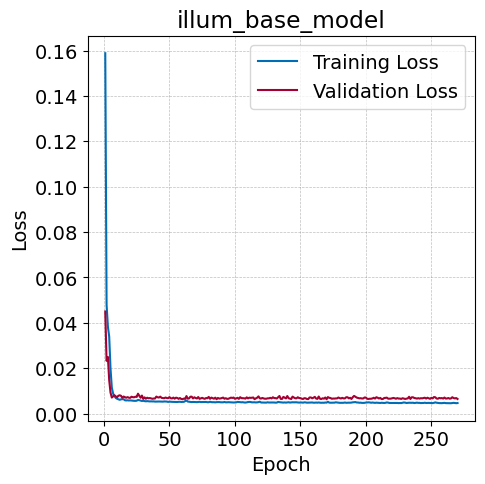

Epoch 1/2000
19/19 [==============================] - 19s 235ms/step - loss: 0.1578 - mean_absolute_error: 0.3401 - val_loss: 0.0540 - val_mean_absolute_error: 0.1697
Epoch 2/2000
19/19 [==============================] - 1s 74ms/step - loss: 0.0628 - mean_absolute_error: 0.1934 - val_loss: 0.0239 - val_mean_absolute_error: 0.1254
Epoch 3/2000
19/19 [==============================] - 1s 75ms/step - loss: 0.0404 - mean_absolute_error: 0.1596 - val_loss: 0.0136 - val_mean_absolute_error: 0.0882
Epoch 4/2000
19/19 [==============================] - 1s 74ms/step - loss: 0.0278 - mean_absolute_error: 0.1300 - val_loss: 0.0116 - val_mean_absolute_error: 0.0800
Epoch 5/2000
19/19 [==============================] - 1s 75ms/step - loss: 0.0197 - mean_absolute_error: 0.1086 - val_loss: 0.0091 - val_mean_absolute_error: 0.0683
Epoch 6/2000
19/19 [==============================] - 1s 74ms/step - loss: 0.0146 - mean_absolute_error: 0.0914 - val_loss: 0.0077 - val_mean_absolute_error: 0.0637
Epoch 7/

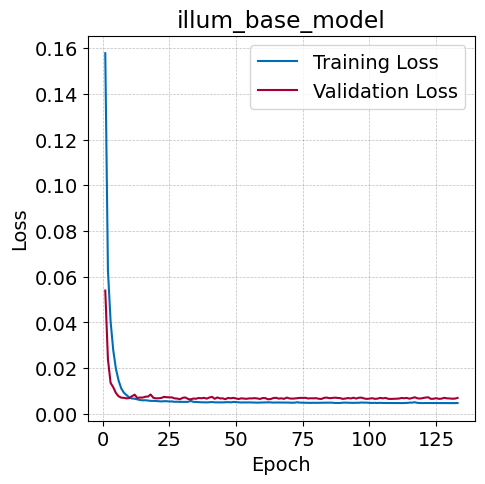

Epoch 1/2000
20/20 [==============================] - 17s 225ms/step - loss: 0.1551 - mean_absolute_error: 0.3407 - val_loss: 0.0578 - val_mean_absolute_error: 0.1992
Epoch 2/2000
20/20 [==============================] - 1s 73ms/step - loss: 0.0517 - mean_absolute_error: 0.1900 - val_loss: 0.0221 - val_mean_absolute_error: 0.1173
Epoch 3/2000
20/20 [==============================] - 1s 73ms/step - loss: 0.0404 - mean_absolute_error: 0.1649 - val_loss: 0.0239 - val_mean_absolute_error: 0.1269
Epoch 4/2000
20/20 [==============================] - 1s 73ms/step - loss: 0.0312 - mean_absolute_error: 0.1423 - val_loss: 0.0095 - val_mean_absolute_error: 0.0724
Epoch 5/2000
20/20 [==============================] - 1s 73ms/step - loss: 0.0156 - mean_absolute_error: 0.0952 - val_loss: 0.0088 - val_mean_absolute_error: 0.0691
Epoch 6/2000
20/20 [==============================] - 1s 73ms/step - loss: 0.0106 - mean_absolute_error: 0.0758 - val_loss: 0.0075 - val_mean_absolute_error: 0.0610
Epoch 7/

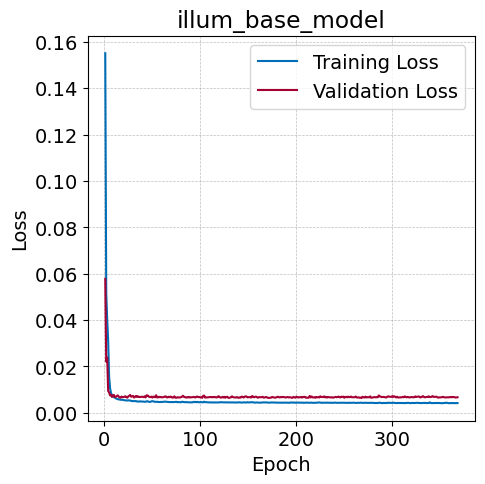

Epoch 1/2000
21/21 [==============================] - 17s 221ms/step - loss: 0.1502 - mean_absolute_error: 0.3329 - val_loss: 0.0256 - val_mean_absolute_error: 0.1311
Epoch 2/2000
21/21 [==============================] - 2s 72ms/step - loss: 0.0451 - mean_absolute_error: 0.1732 - val_loss: 0.0300 - val_mean_absolute_error: 0.1426
Epoch 3/2000
21/21 [==============================] - 2s 73ms/step - loss: 0.0409 - mean_absolute_error: 0.1675 - val_loss: 0.0289 - val_mean_absolute_error: 0.1441
Epoch 4/2000
21/21 [==============================] - 2s 73ms/step - loss: 0.0376 - mean_absolute_error: 0.1607 - val_loss: 0.0181 - val_mean_absolute_error: 0.1131
Epoch 5/2000
21/21 [==============================] - 2s 74ms/step - loss: 0.0258 - mean_absolute_error: 0.1265 - val_loss: 0.0093 - val_mean_absolute_error: 0.0668
Epoch 6/2000
21/21 [==============================] - 2s 74ms/step - loss: 0.0138 - mean_absolute_error: 0.0848 - val_loss: 0.0090 - val_mean_absolute_error: 0.0692
Epoch 7/

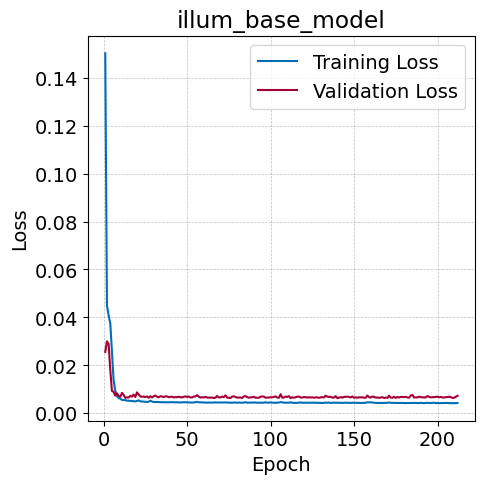

Epoch 1/2000
22/22 [==============================] - 17s 217ms/step - loss: 0.1888 - mean_absolute_error: 0.3753 - val_loss: 0.0459 - val_mean_absolute_error: 0.1712
Epoch 2/2000
22/22 [==============================] - 2s 74ms/step - loss: 0.0749 - mean_absolute_error: 0.2238 - val_loss: 0.0227 - val_mean_absolute_error: 0.1189
Epoch 3/2000
22/22 [==============================] - 2s 74ms/step - loss: 0.0518 - mean_absolute_error: 0.1876 - val_loss: 0.0220 - val_mean_absolute_error: 0.1244
Epoch 4/2000
22/22 [==============================] - 2s 73ms/step - loss: 0.0399 - mean_absolute_error: 0.1619 - val_loss: 0.0179 - val_mean_absolute_error: 0.1116
Epoch 5/2000
22/22 [==============================] - 2s 74ms/step - loss: 0.0318 - mean_absolute_error: 0.1453 - val_loss: 0.0165 - val_mean_absolute_error: 0.1072
Epoch 6/2000
22/22 [==============================] - 2s 77ms/step - loss: 0.0263 - mean_absolute_error: 0.1299 - val_loss: 0.0120 - val_mean_absolute_error: 0.0836
Epoch 7/

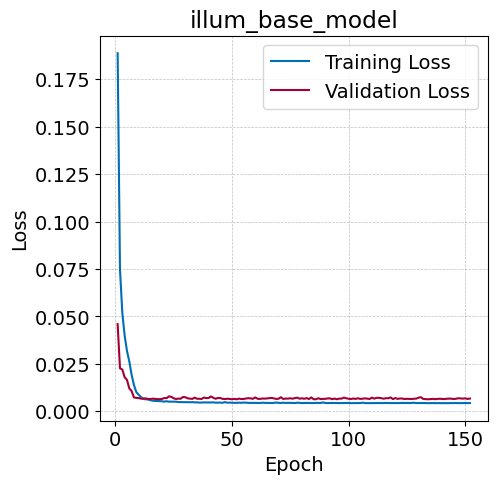

Epoch 1/2000
23/23 [==============================] - 18s 207ms/step - loss: 0.1740 - mean_absolute_error: 0.3628 - val_loss: 0.0530 - val_mean_absolute_error: 0.1970
Epoch 2/2000
23/23 [==============================] - 2s 72ms/step - loss: 0.0632 - mean_absolute_error: 0.1985 - val_loss: 0.0206 - val_mean_absolute_error: 0.1140
Epoch 3/2000
23/23 [==============================] - 2s 72ms/step - loss: 0.0437 - mean_absolute_error: 0.1709 - val_loss: 0.0229 - val_mean_absolute_error: 0.1315
Epoch 4/2000
23/23 [==============================] - 2s 72ms/step - loss: 0.0347 - mean_absolute_error: 0.1531 - val_loss: 0.0171 - val_mean_absolute_error: 0.1054
Epoch 5/2000
23/23 [==============================] - 2s 73ms/step - loss: 0.0223 - mean_absolute_error: 0.1146 - val_loss: 0.0097 - val_mean_absolute_error: 0.0700
Epoch 6/2000
23/23 [==============================] - 2s 72ms/step - loss: 0.0132 - mean_absolute_error: 0.0841 - val_loss: 0.0075 - val_mean_absolute_error: 0.0633
Epoch 7/

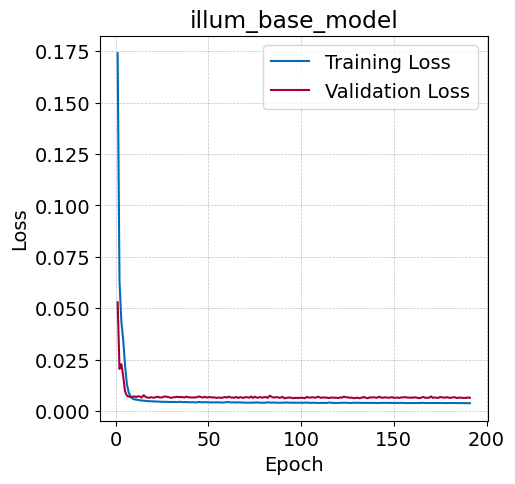

Epoch 1/2000
24/24 [==============================] - 18s 204ms/step - loss: 0.1807 - mean_absolute_error: 0.3678 - val_loss: 0.0575 - val_mean_absolute_error: 0.1901
Epoch 2/2000
24/24 [==============================] - 2s 72ms/step - loss: 0.0686 - mean_absolute_error: 0.2173 - val_loss: 0.0275 - val_mean_absolute_error: 0.1442
Epoch 3/2000
24/24 [==============================] - 2s 73ms/step - loss: 0.0464 - mean_absolute_error: 0.1790 - val_loss: 0.0285 - val_mean_absolute_error: 0.1447
Epoch 4/2000
24/24 [==============================] - 2s 72ms/step - loss: 0.0369 - mean_absolute_error: 0.1594 - val_loss: 0.0175 - val_mean_absolute_error: 0.1123
Epoch 5/2000
24/24 [==============================] - 2s 73ms/step - loss: 0.0216 - mean_absolute_error: 0.1163 - val_loss: 0.0106 - val_mean_absolute_error: 0.0759
Epoch 6/2000
24/24 [==============================] - 2s 72ms/step - loss: 0.0128 - mean_absolute_error: 0.0842 - val_loss: 0.0078 - val_mean_absolute_error: 0.0627
Epoch 7/

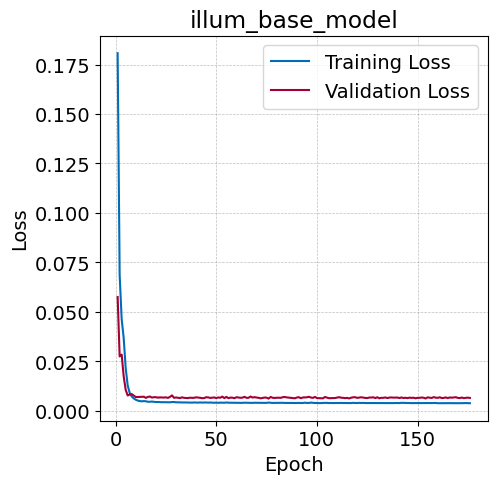

Epoch 1/2000
25/25 [==============================] - 18s 193ms/step - loss: 0.1620 - mean_absolute_error: 0.3414 - val_loss: 0.0394 - val_mean_absolute_error: 0.1533
Epoch 2/2000
25/25 [==============================] - 2s 71ms/step - loss: 0.0589 - mean_absolute_error: 0.1931 - val_loss: 0.0174 - val_mean_absolute_error: 0.1057
Epoch 3/2000
25/25 [==============================] - 2s 71ms/step - loss: 0.0328 - mean_absolute_error: 0.1432 - val_loss: 0.0185 - val_mean_absolute_error: 0.1115
Epoch 4/2000
25/25 [==============================] - 2s 71ms/step - loss: 0.0231 - mean_absolute_error: 0.1229 - val_loss: 0.0144 - val_mean_absolute_error: 0.0911
Epoch 5/2000
25/25 [==============================] - 2s 71ms/step - loss: 0.0160 - mean_absolute_error: 0.1004 - val_loss: 0.0112 - val_mean_absolute_error: 0.0752
Epoch 6/2000
25/25 [==============================] - 2s 74ms/step - loss: 0.0108 - mean_absolute_error: 0.0790 - val_loss: 0.0083 - val_mean_absolute_error: 0.0599
Epoch 7/

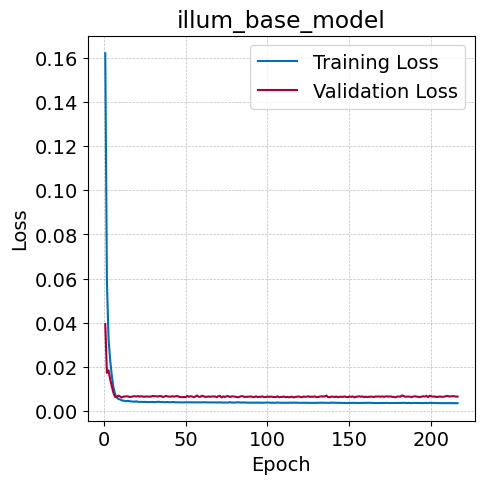

Epoch 1/2000
26/26 [==============================] - 17s 184ms/step - loss: 0.1618 - mean_absolute_error: 0.3341 - val_loss: 0.0297 - val_mean_absolute_error: 0.1172
Epoch 2/2000
26/26 [==============================] - 2s 71ms/step - loss: 0.0560 - mean_absolute_error: 0.1874 - val_loss: 0.0239 - val_mean_absolute_error: 0.1304
Epoch 3/2000
26/26 [==============================] - 2s 71ms/step - loss: 0.0406 - mean_absolute_error: 0.1648 - val_loss: 0.0207 - val_mean_absolute_error: 0.1027
Epoch 4/2000
26/26 [==============================] - 2s 71ms/step - loss: 0.0271 - mean_absolute_error: 0.1232 - val_loss: 0.0173 - val_mean_absolute_error: 0.1010
Epoch 5/2000
26/26 [==============================] - 2s 71ms/step - loss: 0.0179 - mean_absolute_error: 0.1009 - val_loss: 0.0124 - val_mean_absolute_error: 0.0855
Epoch 6/2000
26/26 [==============================] - 2s 71ms/step - loss: 0.0122 - mean_absolute_error: 0.0820 - val_loss: 0.0099 - val_mean_absolute_error: 0.0756
Epoch 7/

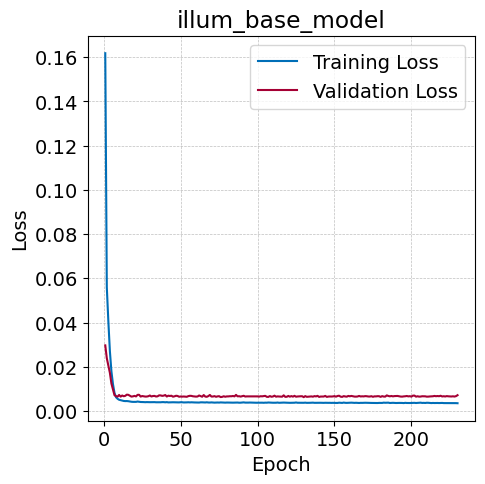

Epoch 1/2000
27/27 [==============================] - 18s 180ms/step - loss: 0.1602 - mean_absolute_error: 0.3377 - val_loss: 0.0360 - val_mean_absolute_error: 0.1470
Epoch 2/2000
27/27 [==============================] - 2s 71ms/step - loss: 0.0509 - mean_absolute_error: 0.1832 - val_loss: 0.0294 - val_mean_absolute_error: 0.1442
Epoch 3/2000
27/27 [==============================] - 2s 70ms/step - loss: 0.0447 - mean_absolute_error: 0.1758 - val_loss: 0.0315 - val_mean_absolute_error: 0.1509
Epoch 4/2000
27/27 [==============================] - 2s 71ms/step - loss: 0.0362 - mean_absolute_error: 0.1530 - val_loss: 0.0175 - val_mean_absolute_error: 0.1009
Epoch 5/2000
27/27 [==============================] - 2s 71ms/step - loss: 0.0162 - mean_absolute_error: 0.0925 - val_loss: 0.0084 - val_mean_absolute_error: 0.0619
Epoch 6/2000
27/27 [==============================] - 2s 71ms/step - loss: 0.0091 - mean_absolute_error: 0.0668 - val_loss: 0.0073 - val_mean_absolute_error: 0.0546
Epoch 7/

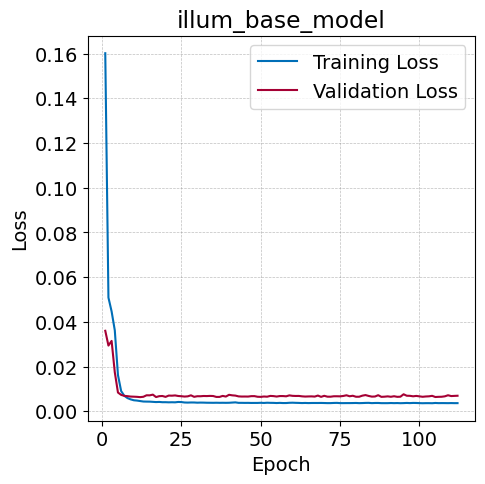

In [27]:
# Creating different base models with different number of simulated orbits added
number_of_orbits = np.arange(1, 11)
base_models = []

for number_of_orbit in number_of_orbits:
    base_train_window_df_temp = pd.concat([base_train_window_df, artificial_df.iloc[:number_of_orbit*95, :]], ignore_index=True)
    base_train_x = np.array(base_train_window_df_temp.iloc[:, 1:-6].to_numpy().reshape(-1, base_window_size, 1), dtype=np.float64)
    base_train_y = np.array(base_train_window_df_temp.iloc[:, -6:].to_numpy(), dtype=np.float64)
    
    base_model = Model(base_train_x.astype(np.float64), base_train_y.astype(np.float64), base_test_x.astype(np.float64), base_test_y.astype(np.float64), "illum_base_model")
    base_model.create_model(
        base_model_layers,
        tf.keras.optimizers.Adam(learning_rate=1e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(None, 1),
        output_shape=6,
    )
    base_model.train_model(2000, base_early_stopping)
    base_models.append(base_model.model)
    # base_model.train_model(200)

In [84]:
# Fully data driven model:
base_train_window_df, base_train_x, base_train_y = window_data_base_illumination(train_norm_df, base_window_size, illumination_data)
base_test_window_df, base_test_x, base_test_y = window_data_base_illumination(test_norm_df, base_window_size, illumination_data)


[==>                                     ] - 133/1684 [8%] in 0s (~4s, 391.1/s) 

[========================================] 1684/1684 [100%] in 6.7s (255.13/s)                                          
[========================================] 422/422 [100%] in 1.1s (394.63/s)                                            


In [ ]:

data_driven_base = Model(base_train_x.astype(np.float64), base_train_y.astype(np.float64), base_test_x.astype(np.float64), base_test_y.astype(np.float64), "illum_data_driven")
data_driven_base.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)
data_driven_base.train_model(2000, base_early_stopping)


In [91]:
actual = denormalize_temperature(base_test_y, norm_limits)
data_driven_predicted = denormalize_temperature(data_driven_base.model.predict(base_test_x.astype(np.float64)), norm_limits)

errors = (actual - data_driven_predicted).astype(np.float64)

14/14 [==============================] - 0s 18ms/step


0.5945277824221062
5.779184789901284


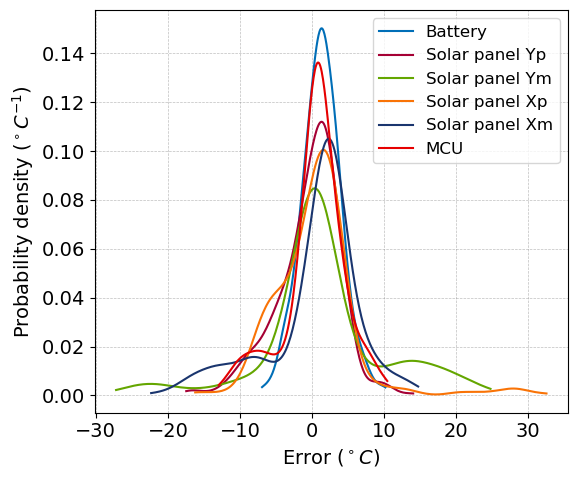

In [93]:
kde_vals, bins = kde(
    errors,
    plot_kde=False,
)
labels = ["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"]
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
for i in range(6):
    ax.plot(bins[i], kde_vals[i], label=labels[i],  color=plt_colors[i])
ax.set_xlabel(r"Error ($^\circ C$)")
ax.set_ylabel(r"Probability density ($^\circ C^{-1}$)")
ax.grid()
ax.legend(fontsize=12)

print(np.nanmean(errors))
print(np.nanstd(errors))
fig.savefig("../../report/images/chapter-4/delfi-pq-illum-base-kde.pdf")

In [29]:
artificial_test_x = np.array(artificial_df.iloc[1047:1141, 1:-6].to_numpy().reshape(-1, base_window_size, 1), dtype=np.float64)
artificial_test_y = np.array(artificial_df.iloc[1047:1141, -6:].to_numpy(), dtype=np.float64)
artificial_theta_T = artificial_df.iloc[1047:1141, 0].to_numpy()


In [30]:
#Plotting the performance of the base models on the artificial orbit
errors_1 = []
errors_2 = []
actual_1 = denormalize_temperature(base_test_y, norm_limits)
actual_2 = denormalize_temperature(artificial_test_y, norm_limits)

for idx in range(len(base_models)):
    predicted_1 = denormalize_temperature(base_models[idx].predict(base_test_x.astype(np.float64)), norm_limits)
    predicted_2 = denormalize_temperature(base_models[idx].predict(artificial_test_x), norm_limits)
    
    errors_1.append(actual_1 - predicted_1)
    errors_2.append(actual_2 - predicted_2)

3/3 [==============================] - 0s 14ms/step


In [31]:
base_errors_1 = actual_1 - denormalize_temperature(data_driven_base.model.predict(base_test_x.astype(np.float64)), norm_limits)
base_errors_2 = actual_2 - denormalize_temperature(data_driven_base.model.predict(artificial_test_x), norm_limits)


3/3 [==============================] - 0s 14ms/step


In [32]:
errors_1 = np.array(errors_1)
errors_2 = np.array(errors_2)

errors_1 = np.concatenate([base_errors_1.reshape(1, 422, 6), errors_1], axis=0)
errors_2 = np.concatenate([base_errors_2.reshape(1, 94, 6), errors_2], axis=0)


In [43]:
# np.mean(errors_1, axis=(1, 2)).shape
for i in range(11):
    print(np.std(errors_1[i]))

5.779184789901284
5.738792657340779
5.807964760846459
5.796218063835134
5.761289807477694
5.756823791357439
5.770497823191017
5.762381881375769
5.761856915494497
5.713662226951429
5.772693104744304


In [50]:
mu_1 = np.mean(errors_1, axis=(1, 2))
sigma_1 = np.array([np.std(errors_1[i]) for i in range(11)])
mu_2 = np.mean(errors_2, axis=(1, 2))
sigma_2 = np.array([np.std(errors_2[i]) for i in range(11)])


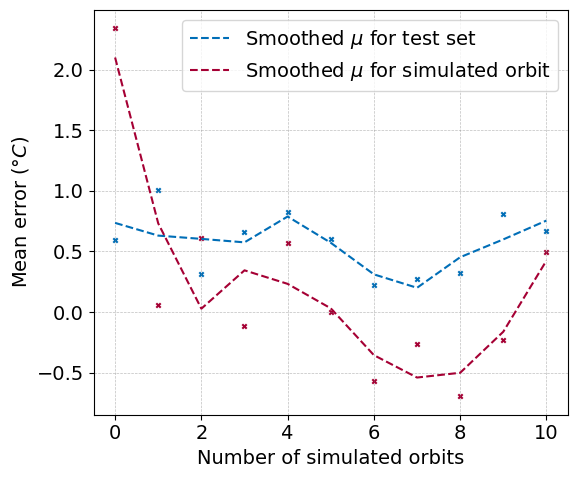

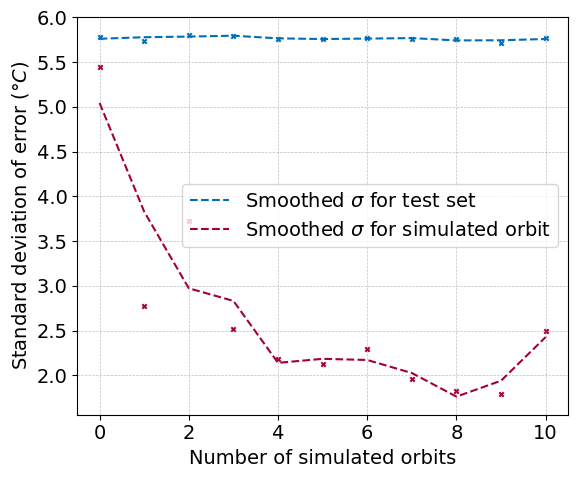

In [78]:
steps = np.arange(0, 11)
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(steps, mu_1, color=plt_colors[0], marker="x", s=10)
ax.scatter(steps, mu_2, color=plt_colors[1], marker="x", s=10)
ax.plot(steps, savgol_filter(mu_1, 5, 2), color=plt_colors[0], label=r"Smoothed $\mu$ for test set", linestyle="--")
ax.plot(steps, savgol_filter(mu_2, 5, 2), color=plt_colors[1], label=r"Smoothed $\mu$ for simulated orbit", linestyle="--")
ax.grid()
ax.set_xlabel("Number of simulated orbits")
ax.set_ylabel(r"Mean error $(\degree C)$")
ax.legend()

fig.savefig(f"../../report/images/chapter-5/curve-fit-model-error-mu.pdf")

fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(steps, sigma_1, color=plt_colors[0], marker="x", s=10)
ax.scatter(steps, sigma_2, color=plt_colors[1], marker="x", s=10)
ax.plot(steps, savgol_filter(sigma_1, 5, 2), color=plt_colors[0], label=r"Smoothed $\sigma$ for test set", linestyle="--")
ax.plot(steps, savgol_filter(sigma_2, 5, 2), color=plt_colors[1], label=r"Smoothed $\sigma$ for simulated orbit", linestyle="--")
ax.grid()
ax.set_xlabel("Number of simulated orbits")
ax.set_ylabel(r"Standard deviation of error $(\degree C)$")
ax.legend()
fig.savefig(f"../../report/images/chapter-5/curve-fit-model-error-sigma.pdf")
plt.show()

In [52]:
idxs = [0, 3, 6, 9]
theta_T_vals = [artificial_theta_T]
temp_vals = [denormalize_temperature(data_driven_base.model.predict(artificial_test_x), norm_limits)]
scatter = [False]
for idx in idxs:
    theta_T_vals.append(artificial_theta_T)
    temp_vals.append(denormalize_temperature(base_models[idx].predict(artificial_test_x), norm_limits))
    scatter.append(False)

theta_T_vals.append(artificial_theta_T)
temp_vals.append(denormalize_temperature(artificial_test_y, norm_limits))
scatter.append(True)


3/3 [==============================] - 0s 19ms/step


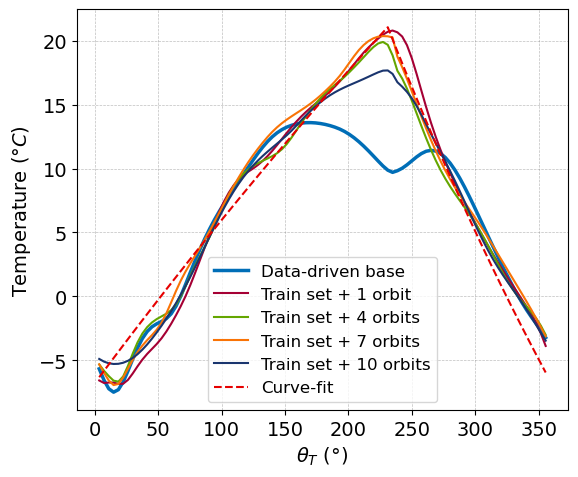

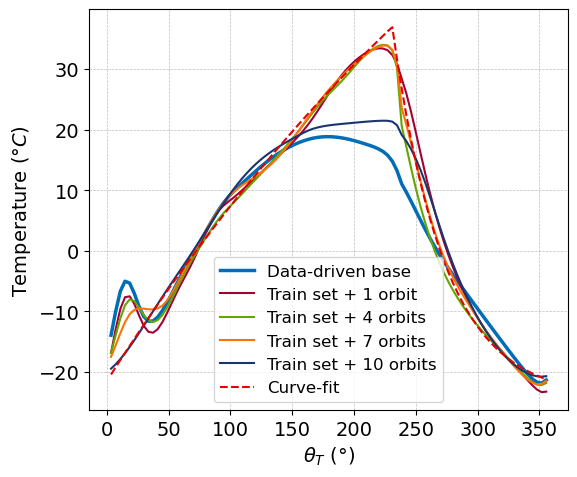

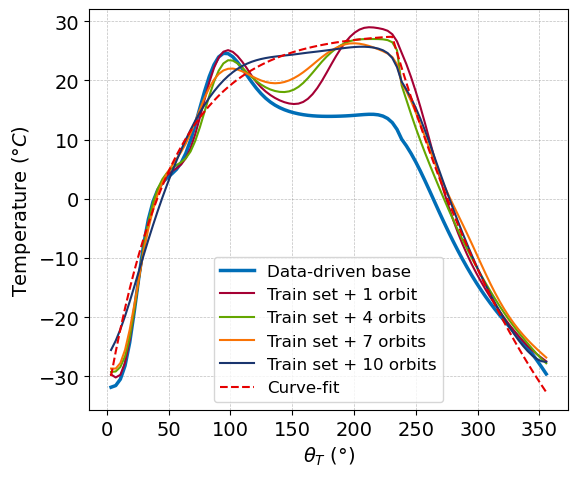

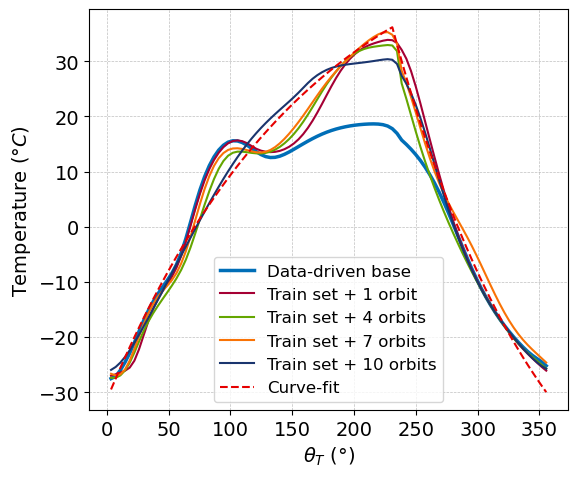

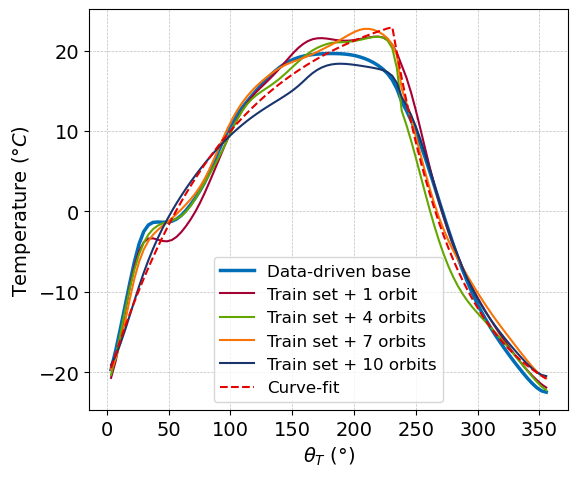

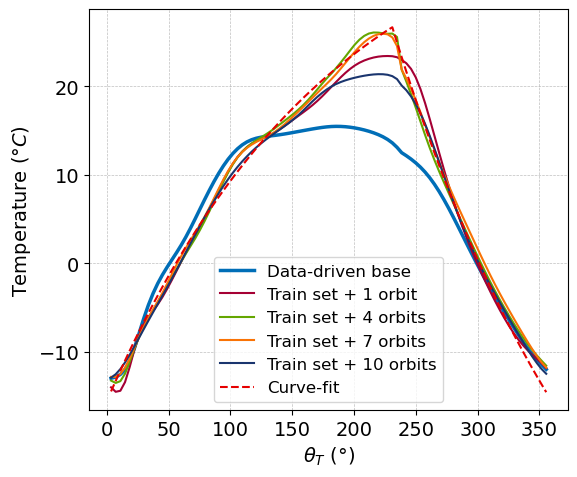

In [55]:
plt_labels = ["battery", "panel-yp", "panel-ym", "panel-xp", "panel-xm", "MCU"]
line_labels = ["Data-driven base", "Train set + 1 orbit", "Train set + 4 orbits", "Train set + 7 orbits", "Train set + 10 orbits", "Curve-fit"]
for i in range(6):
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    for j in range(len(theta_T_vals)):
        if j == 0:
            linewidth = 2.5
        else:
            linewidth = 1.5
        linestyle = "--" if scatter[j] else "-"
        ax.plot(theta_T_vals[j], temp_vals[j][:, i], color=plt_colors[j], linestyle=linestyle, linewidth=linewidth, label=f"{line_labels[j]}")
    ax.set_xlabel(r"$\theta_T$ ($\degree$)")
    ax.set_ylabel(r"Temperature $(\degree C)$")
    ax.legend(fontsize=12)
    ax.grid()
    
    fig.savefig(f"../../report/images/chapter-5/curve-fit-model-{plt_labels[i]}.pdf")

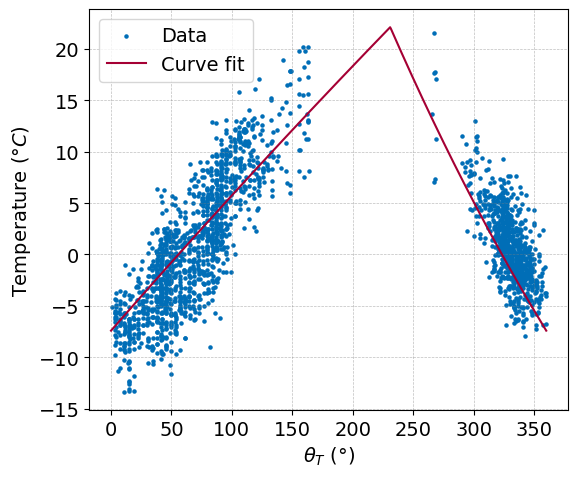

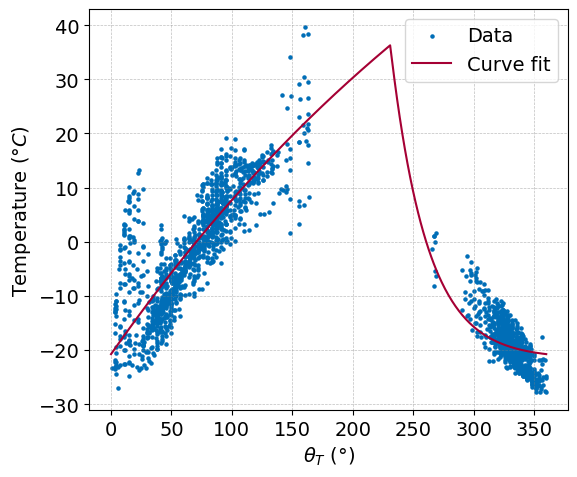

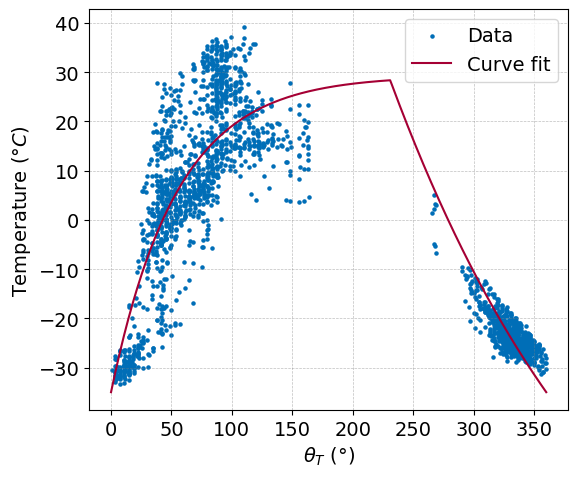

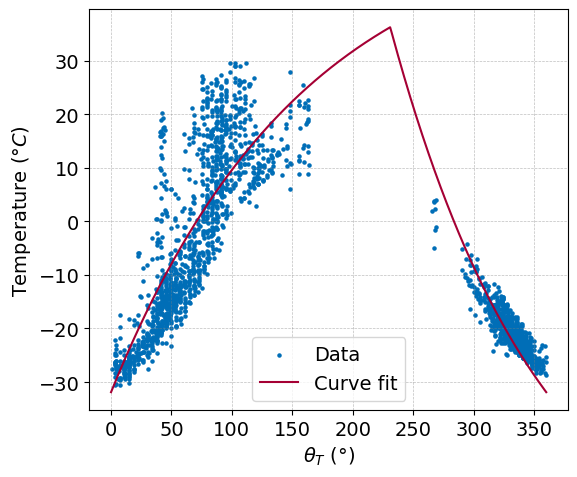

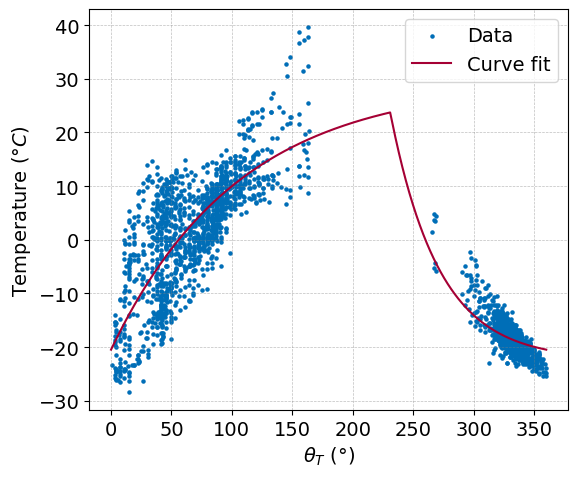

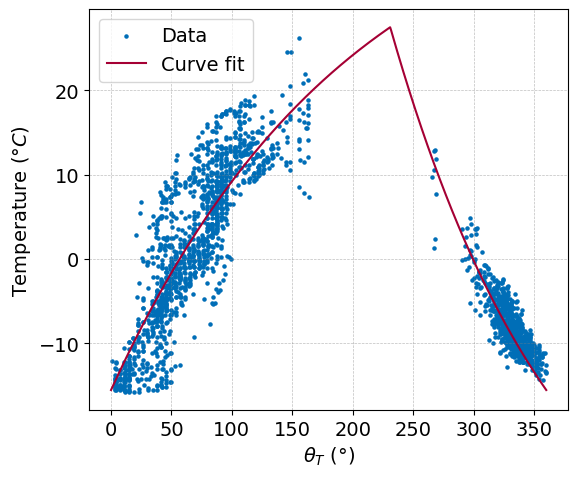

In [57]:
for i in range(6):
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.scatter(telem_processed_df["theta_T (deg)"], telem_processed_df.iloc[:, -6+i], s=5, color=plt_colors[0], label="Data")
    ax.plot(theta_T_fit, temp_fit[:, i], color=plt_colors[1], label="Curve fit")
    ax.set_xlabel(r"$\theta_T$ ($\degree$)")
    ax.set_ylabel(r"Temperature $(\degree C)$")
    ax.legend()
    ax.grid()
    
    fig.savefig(f"../../report/images/chapter-5/curve-fit-{plt_labels[i]}-fit.pdf")

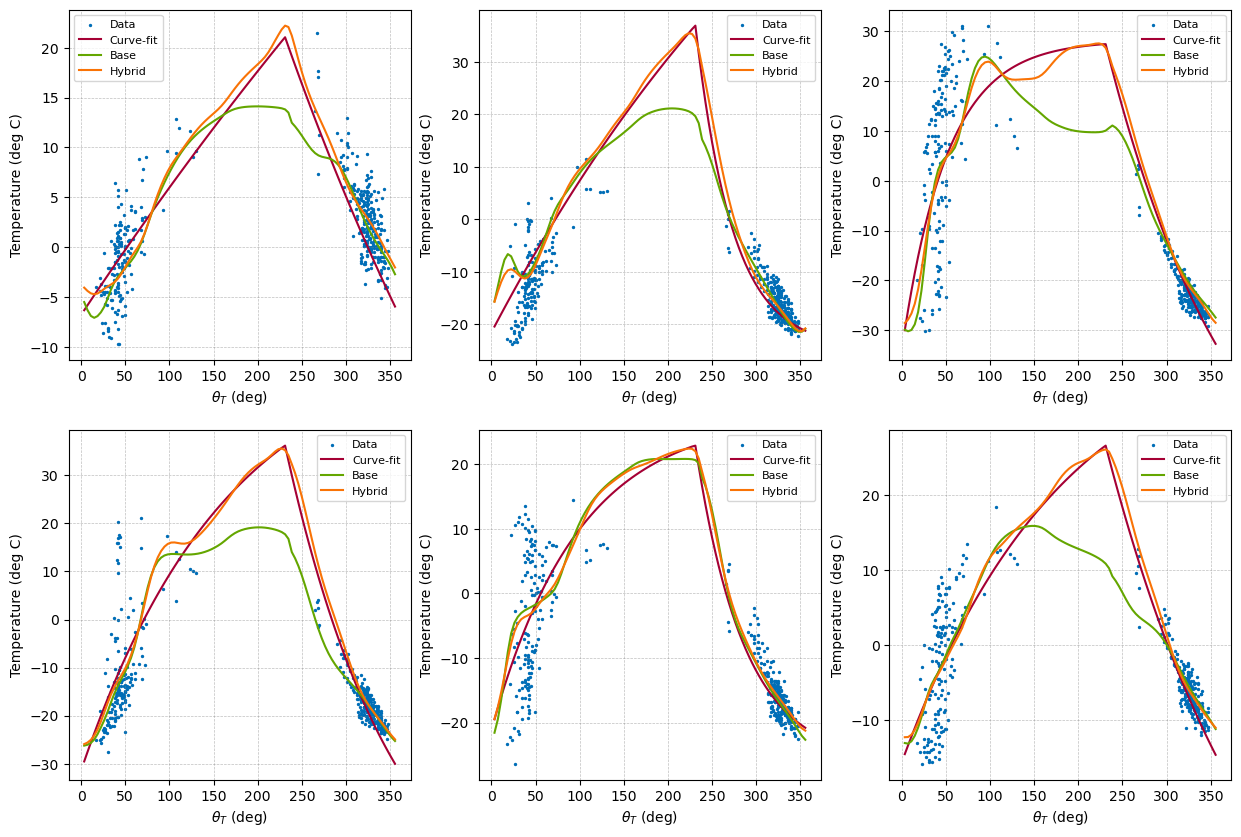

In [49]:
theta_T_vals = [base_test_window_df["theta_T"].to_numpy(), artificial_theta_T, artificial_theta_T, artificial_theta_T]
temp_vals = [
    denormalize_temperature(base_test_y, norm_limits),
    denormalize_temperature(artificial_test_y, norm_limits),
    denormalize_temperature(base_predictions, norm_limits),
    denormalize_temperature(predictions, norm_limits),
]
_ = plot_model(theta_T_vals, temp_vals, labels=["Data", "Curve-fit", "Base", "Hybrid"], plt_scatter=[True, False, False, False])

In [58]:
def window_data_res_illumination_all_channels(df, base_window_size, base_model, res_window_size, check_continuous=True):
    df = df.copy()
    columns = np.concatenate(
        (
            ["theta_T"],
            ["batte in " + str(i) for i in range(res_window_size)],
            ["silver chassis in " + str(i) for i in range(res_window_size)],
            ["black panel in " + str(i) for i in range(res_window_size)],
            ["silver panel in " + str(i) for i in range(res_window_size)],
            ["solar panel +X in " + str(i) for i in range(res_window_size)],
            ["solar panel -X in " + str(i) for i in range(res_window_size)],
            ["solar panel +Y in " + str(i) for i in range(res_window_size)],
            ["solar panel -Y in " + str(i) for i in range(res_window_size)],
            ["black chassis pred"],
            ["silver chassis pred"],
            ["black panel pred"],
            ["silver panel pred"],
            ["solar panel +X pred"],
            ["solar panel -X pred"],
            ["solar panel +Y pred"],
            ["solar panel -Y pred"],
            ["black chassis out"],
            ["silver chassis out"],
            ["black panel out"],
            ["silver panel out"],
            ["solar panel +X out"],
            ["solar panel -X out"],
            ["solar panel +Y out"],
            ["solar panel -Y out"],
        )
    )

    window_df = pd.DataFrame(columns=columns, dtype=np.float64)
    illum_list = []

    with alive_bar(df.shape[0] - base_window_size, theme="classic", force_tty=True) as bar:
        for i in range(df.shape[0] - base_window_size):
            if check_continuous and (
                df.loc[i + base_window_size, "time (jd)"] - df.loc[i, "time (jd)"] > 1.25 * (i * 24 * 60)
            ):
                bar()
                continue

            window_df.loc[i, "theta_T"] = df.loc[i + base_window_size, "theta_T (deg)"]
            illumination = df.loc[i : i + base_window_size - 1, "illumination"].to_numpy()
            illum_list.append(illumination)
            # pred = base_model.predict(illumination.reshape(1, base_window_size, 1), verbose=0).flatten()[0]
            window_df.loc[i, "black chassis in 0":f"black chassis in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "black chassis temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "silver chassis in 0":f"silver chassis in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "silver chassis temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "black panel in 0":f"black panel in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "black panel temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "silver panel in 0":f"silver panel in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "silver panel temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel +X in 0":f"solar panel +X in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel +X temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel -X in 0":f"solar panel -X in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel -X temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel +Y in 0":f"solar panel +Y in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel +Y temperature (deg C)"
            ].to_numpy()
            window_df.loc[i, "solar panel -Y in 0":f"solar panel -Y in {res_window_size-1}"] = df.loc[
                i + base_window_size - res_window_size : i + base_window_size - 1, "solar panel -Y temperature (deg C)"
            ].to_numpy()
            
            # window_df.loc[i, "black panel pred"] = pred
            # window_df.loc[i, "black panel out"] = df.loc[i + base_window_size, "black panel temperature (deg C)"] - pred
            bar()
            
    preds = base_model.predict(np.array(illum_list).reshape(-1, base_window_size, 1), verbose=0)
    window_df.loc[:, "black chassis pred":"solar panel -Y pred"] = preds
    
    for i, row in window_df.iterrows():
        window_df.loc[i, "black chassis out"] = df.loc[i + base_window_size, "black chassis temperature (deg C)"] - row["black chassis pred"]
        window_df.loc[i, "silver chassis out"] = df.loc[i + base_window_size, "silver chassis temperature (deg C)"] - row["silver chassis pred"]
        window_df.loc[i, "black panel out"] = df.loc[i + base_window_size, "black panel temperature (deg C)"] - row["black panel pred"]
        window_df.loc[i, "silver panel out"] = df.loc[i + base_window_size, "silver panel temperature (deg C)"] - row["silver panel pred"]
        window_df.loc[i, "solar panel +X out"] = df.loc[i + base_window_size, "solar panel +X temperature (deg C)"] - row["solar panel +X pred"]
        window_df.loc[i, "solar panel -X out"] = df.loc[i + base_window_size, "solar panel -X temperature (deg C)"] - row["solar panel -X pred"]
        window_df.loc[i, "solar panel +Y out"] = df.loc[i + base_window_size, "solar panel +Y temperature (deg C)"] - row["solar panel +Y pred"]
        window_df.loc[i, "solar panel -Y out"] = df.loc[i + base_window_size, "solar panel -Y temperature (deg C)"] - row["solar panel -Y pred"]

    x = np.zeros((window_df.shape[0], 8*(res_window_size+1)), dtype=np.float64)
    y = np.zeros((window_df.shape[0], 8), dtype=np.float64)

    x = window_df.iloc[:, 1:-8].to_numpy(dtype=np.float64)
    y = window_df.iloc[:, -8:].to_numpy(dtype=np.float64)

    return window_df, x, y

In [59]:
# Checking contiguity of available temperature data:
contiguity_train_df = telem_processed_df.iloc[:int(0.8*len(telem_processed_df))].copy()

# Pass: when subsequent datapoints are within 1 minute of each other
contiguity_train_df["Pass"] = np.nan

pass_no = 0
contiguity_train_df.loc[0, "Pass"] = pass_no
for i in range(1, len(contiguity_train_df)):
    if contiguity_train_df["time (jd)"][i] - contiguity_train_df["time (jd)"][i-1] > 1.1/1440:
        pass_no += 1
    contiguity_train_df.loc[i, "Pass"] = pass_no

pass_train_df = pd.DataFrame(columns=["pass", "count"], index=range(pass_no+1))
for i in range(pass_no+1):
    pass_train_df.loc[i, "pass"] = i
    pass_train_df.loc[i, "count"] = len(contiguity_train_df[contiguity_train_df["Pass"] == i])

count_df = pd.DataFrame(columns=["count", "train no", "test no"], index=range(1, max(pass_train_df["count"])+1))
for i in range(1, max(pass_train_df["count"])+1):
    count_df.loc[i, "count"] = i
    count_df.loc[i, "train no"] = len(pass_train_df[pass_train_df["count"] == i])

contiguity_test_df = test_norm_df.copy().reset_index(drop=True)
contiguity_test_df["Pass"] = np.nan
pass_no = 0
contiguity_test_df.loc[0, "Pass"] = pass_no

for i in range(1, len(contiguity_test_df)):
    if contiguity_test_df["time (jd)"][i] - contiguity_test_df["time (jd)"][i-1] > 1.1/1440:
        pass_no += 1
    contiguity_test_df.loc[i, "Pass"] = pass_no

pass_test_df = pd.DataFrame(columns=["pass", "count"], index=range(pass_no+1))
for i in range(pass_no+1):
    pass_test_df.loc[i, "pass"] = i
    pass_test_df.loc[i, "count"] = len(contiguity_test_df[contiguity_test_df["Pass"] == i])

for i in range(1, max(pass_test_df["count"])+1):
    count_df.loc[i, "test no"] = len(pass_test_df[pass_test_df["count"] == i])

print(count_df)

   count train no test no
1      1      442     139
2      2      223      57
3      3      100      35
4      4       54       8
5      5       19       4
6      6       12       2
7      7        6     NaN
8      8        3     NaN
9      9        3     NaN
10    10        2     NaN


In [60]:
def window_data_res(base_df, base_preds, res_window_size, return_numpy=True):
    """
    Function to create the data for the residual model.
    :param df: dataframe to create the data from
    :param base_window_size: window size of the base model (illumination data)
    :param res_window_size: window size of the residual model (temperature data)
    :param base_model: base model to use
    :param return_numpy: boolean to return input and output numpy arrays for the model
    :param check_continuity: boolean to check if the data is continuous

    :return: dataframe with the windowed data (and) input numpy array, output numpy array
    """

    # Columns of the residual model dataframe
    columns = np.concatenate((
        ["time (jd)"],
        ["theta_T"],
        ["input battery temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Yp temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Ym temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Xp temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Xm temp " + str(i) for i in range(res_window_size)],
        ["input MCU temp " + str(i) for i in range(res_window_size)],
        ["predicted battery temp"],
        ["predicted solar panel Yp temp"],
        ["predicted solar panel Ym temp"],
        ["predicted solar panel Xp temp"],
        ["predicted solar panel Xm temp"],
        ["predicted MCU temp"],
        ["output battery temp"],
        ["output solar panel Yp temp"],
        ["output solar panel Ym temp"],
        ["output solar panel Xp temp"],
        ["output solar panel Xm temp"],
        ["output MCU temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(base_df) - res_window_size))  # create the dataframe

    with alive_bar(len(window_df), theme="classic", title="Creating windowed data", force_tty=True) as bar:
        for i in range(len(window_df)):
            if base_df.loc[i + res_window_size, "time (jd)"] - base_df.loc[i, "time (jd)"] > res_window_size * 1.1 / 1440:
                bar()
                continue
            
            window_df.loc[i, "time (jd)"] = base_df.loc[i + res_window_size, "time (jd)"]
            window_df.loc[i, "theta_T"] = base_df.loc[i + res_window_size, "theta_T (deg)"]
            window_df.loc[i, "input battery temp 0":"input battery temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "battery TMP20 temperature (deg C)"].values
            window_df.loc[i, "input solar panel Yp temp 0":"input solar panel Yp temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Yp temperature (deg C)"].values
            window_df.loc[i, "input solar panel Ym temp 0":"input solar panel Ym temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Ym temperature (deg C)"].values
            window_df.loc[i, "input solar panel Xp temp 0":"input solar panel Xp temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Xp temperature (deg C)"].values
            window_df.loc[i, "input solar panel Xm temp 0":"input solar panel Xm temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Xm temperature (deg C)"].values
            window_df.loc[i, "input MCU temp 0":"input MCU temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "MCU temperature (deg C)"].values
            window_df.loc[i, "predicted battery temp":"predicted MCU temp"] = base_preds[i + res_window_size]
            window_df.loc[i, "output battery temp"] = base_df.loc[i + res_window_size, "battery TMP20 temperature (deg C)"]
            window_df.loc[i, "output solar panel Yp temp"] = base_df.loc[i + res_window_size, "solar panel Yp temperature (deg C)"]
            window_df.loc[i, "output solar panel Ym temp"] = base_df.loc[i + res_window_size, "solar panel Ym temperature (deg C)"]
            window_df.loc[i, "output solar panel Xp temp"] = base_df.loc[i + res_window_size, "solar panel Xp temperature (deg C)"]
            window_df.loc[i, "output solar panel Xm temp"] = base_df.loc[i + res_window_size, "solar panel Xm temperature (deg C)"]
            window_df.loc[i, "output MCU temp"] = base_df.loc[i + res_window_size, "MCU temperature (deg C)"]

            bar()

    # Removing rows with all NaN values
    window_df = window_df.dropna(how="all").reset_index(drop=True)

    if return_numpy:
        # Create the input and output numpy arrays
        x_data = np.empty(shape=(len(window_df), 6 * res_window_size + 6), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 6), dtype=np.float64)

        x_data = window_df.iloc[:, 2:-6].to_numpy(dtype=np.float64)
        y_data = window_df.iloc[:, -6:].to_numpy(dtype=np.float64)

        return window_df, x_data, y_data

In [61]:
base_preds_train = data_driven_base.model.predict(data_driven_base.train_x.astype(np.float64))
base_preds_test = data_driven_base.model.predict(data_driven_base.test_x.astype(np.float64))
shapes = []

for i in range(2, 3):
    res_train_df, res_train_x, res_train_y = window_data_res(train_norm_df.reset_index(drop=True), base_preds_train, i)
    res_test_df, res_test_x, res_test_y = window_data_res(test_norm_df.reset_index(drop=True), base_preds_test, i)
    shapes.append([res_train_df.shape, res_test_df.shape])


14/14 [==============================] - 0s 17ms/step
Creating windowed data [========================================] 1682/1682 [100%] in 1.5s (1090.10/s)                  
Creating windowed data [========================================] 420/420 [100%] in 0.3s (1669.39/s)                    


In [62]:
res_train_x.shape

(401, 18)

In [63]:
res_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
res_model_layers[0] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[1] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[2] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[3] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[4] = {
    "type": "Dense",
    "units": 64,
    "activation": "relu",
}
res_model_layers[5] = {
    "type": "Dense",
    "units": 32,
    "activation": "relu",
}
res_model_layers[6] = {
    "type": "Dense",
    "units": 16,
    "activation": "relu",
}

res_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True,
    min_delta=1e-6,
)   # early stopping callback

53/53 [==============================] - 1s 17ms/step
Creating windowed data [========================================] 1683/1683 [100%] in 3.3s (509.81/s)                   
Creating windowed data [========================================] 421/421 [100%] in 0.7s (616.63/s)                     
Epoch 1/3500
9/9 [==============================] - 4s 40ms/step - loss: 0.1988 - mean_absolute_error: 0.4019 - val_loss: 0.1192 - val_mean_absolute_error: 0.3141
Epoch 2/3500
9/9 [==============================] - 0s 13ms/step - loss: 0.1782 - mean_absolute_error: 0.3792 - val_loss: 0.1068 - val_mean_absolute_error: 0.2968
Epoch 3/3500
9/9 [==============================] - 0s 12ms/step - loss: 0.1612 - mean_absolute_error: 0.3582 - val_loss: 0.0932 - val_mean_absolute_error: 0.2757
Epoch 4/3500
9/9 [==============================] - 0s 13ms/step - loss: 0.1412 - mean_absolute_error: 0.3310 - val_loss: 0.0775 - val_mean_absolute_error: 0.2485
Epoch 5/3500
9/9 [==============================] - 

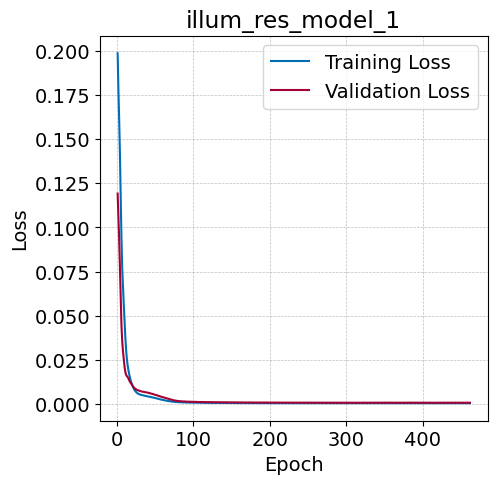

Creating windowed data [========================================] 1682/1682 [100%] in 1.5s (1125.20/s)                  
Creating windowed data [========================================] 420/420 [100%] in 0.3s (1811.82/s)                    
Epoch 1/3500
5/5 [==============================] - 4s 79ms/step - loss: 0.1902 - mean_absolute_error: 0.3914 - val_loss: 0.1177 - val_mean_absolute_error: 0.3109
Epoch 2/3500
5/5 [==============================] - 0s 17ms/step - loss: 0.1742 - mean_absolute_error: 0.3727 - val_loss: 0.1096 - val_mean_absolute_error: 0.2980
Epoch 3/3500
5/5 [==============================] - 0s 16ms/step - loss: 0.1620 - mean_absolute_error: 0.3582 - val_loss: 0.1026 - val_mean_absolute_error: 0.2869
Epoch 4/3500
5/5 [==============================] - 0s 16ms/step - loss: 0.1518 - mean_absolute_error: 0.3451 - val_loss: 0.0954 - val_mean_absolute_error: 0.2750
Epoch 5/3500
5/5 [==============================] - 0s 16ms/step - loss: 0.1413 - mean_absolute_error: 0.3

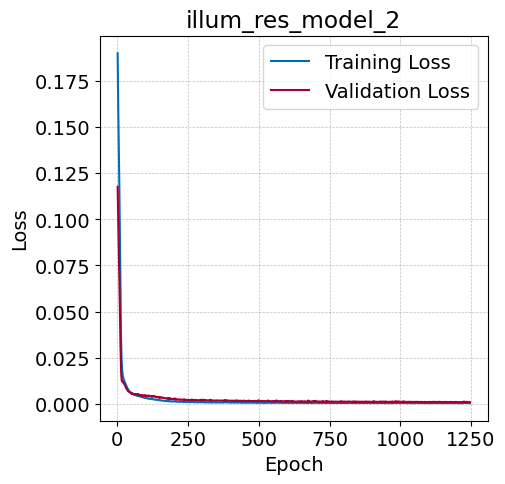

Creating windowed data [========================================] 1681/1681 [100%] in 0.8s (1787.27/s)                  
Creating windowed data [========================================] 419/419 [100%] in 0.1s (9315.17/s)                    
Epoch 1/3500
2/2 [==============================] - 4s 251ms/step - loss: 0.2033 - mean_absolute_error: 0.4067 - val_loss: 0.1581 - val_mean_absolute_error: 0.3668
Epoch 2/3500
2/2 [==============================] - 0s 54ms/step - loss: 0.1980 - mean_absolute_error: 0.4009 - val_loss: 0.1543 - val_mean_absolute_error: 0.3618
Epoch 3/3500
2/2 [==============================] - 0s 54ms/step - loss: 0.1931 - mean_absolute_error: 0.3954 - val_loss: 0.1506 - val_mean_absolute_error: 0.3567
Epoch 4/3500
2/2 [==============================] - 0s 53ms/step - loss: 0.1893 - mean_absolute_error: 0.3908 - val_loss: 0.1486 - val_mean_absolute_error: 0.3540
Epoch 5/3500
2/2 [==============================] - 0s 53ms/step - loss: 0.1879 - mean_absolute_error: 0.

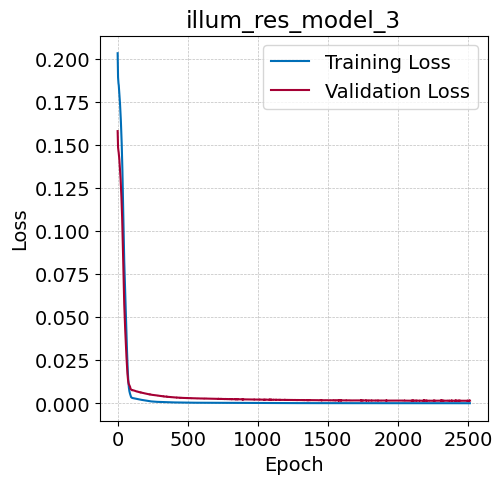

Creating windowed data [========================================] 1680/1680 [100%] in 0.4s (2592.60/s)                  
Creating windowed data [========================================] 418/418 [100%] in 0.0s (16628.62/s)                   
Epoch 1/3500
1/1 [==============================] - 3s 3s/step - loss: 0.1957 - mean_absolute_error: 0.3971 - val_loss: 0.1757 - val_mean_absolute_error: 0.3855
Epoch 2/3500
1/1 [==============================] - 0s 60ms/step - loss: 0.1915 - mean_absolute_error: 0.3927 - val_loss: 0.1723 - val_mean_absolute_error: 0.3815
Epoch 3/3500
1/1 [==============================] - 0s 50ms/step - loss: 0.1876 - mean_absolute_error: 0.3883 - val_loss: 0.1693 - val_mean_absolute_error: 0.3778
Epoch 4/3500
1/1 [==============================] - 0s 60ms/step - loss: 0.1840 - mean_absolute_error: 0.3844 - val_loss: 0.1667 - val_mean_absolute_error: 0.3747
Epoch 5/3500
1/1 [==============================] - 0s 57ms/step - loss: 0.1811 - mean_absolute_error: 0.381

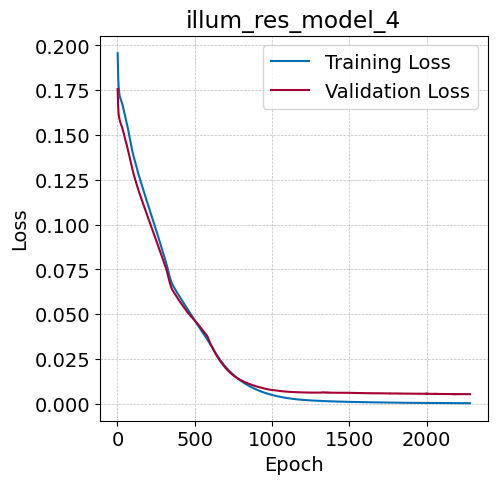

In [64]:
base_preds = data_driven_base.model.predict(base_train_x.astype(np.float64))
res_window_sizes = np.arange(1, 5)
res_models = []

for res_window_size in res_window_sizes:
    res_train_df, res_train_x, res_train_y = window_data_res(train_norm_df.reset_index(drop=True), base_preds_train, res_window_size)
    res_test_df, res_test_x, res_test_y = window_data_res(test_norm_df.reset_index(drop=True), base_preds_test, res_window_size)
    
    res_model = Model(res_train_x.astype(np.float64), res_train_y.astype(np.float64), res_test_x.astype(np.float64), res_test_y.astype(np.float64), f"illum_res_model_{res_window_size}")
    
    res_model.create_model(
        res_model_layers,
        tf.keras.optimizers.Adam(learning_rate=1e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(6*(res_window_size+1),),
        output_shape=6,
    )
    
    res_model.train_model(3500, res_early_stopping)
    res_models.append(res_model.model)

In [65]:
errors = []
base_preds_train = data_driven_base.model.predict(data_driven_base.train_x.astype(np.float64))
base_preds_test = data_driven_base.model.predict(data_driven_base.test_x.astype(np.float64))
for idx, res_window_size in enumerate(res_window_sizes):
    res_train_df, res_train_x, res_train_y = window_data_res(train_norm_df.reset_index(drop=True), base_preds_train, res_window_size)
    res_test_df, res_test_x, res_test_y = window_data_res(test_norm_df.reset_index(drop=True), base_preds_test, res_window_size)
    
    actual = denormalize_temperature(res_test_y, norm_limits)
    base_preds_temp = res_test_df.iloc[:, -12:-6].to_numpy()
    res_preds = res_models[idx].predict(res_test_x.astype(np.float64))
    combined_preds = res_preds
    combined_preds = denormalize_temperature(combined_preds, norm_limits)
    
    errors.append(actual - combined_preds)

14/14 [==============================] - 0s 15ms/step
Creating windowed data [========================================] 1683/1683 [100%] in 3.0s (576.53/s)                   
Creating windowed data [========================================] 421/421 [100%] in 0.7s (600.30/s)                     
6/6 [==============================] - 0s 2ms/step
Creating windowed data [========================================] 1682/1682 [100%] in 1.4s (1156.73/s)                  
Creating windowed data [========================================] 420/420 [100%] in 0.3s (2134.21/s)                    
3/3 [==============================] - 0s 2ms/step
Creating windowed data [========================================] 1681/1681 [100%] in 0.8s (1592.59/s)                  
Creating windowed data [========================================] 419/419 [100%] in 0.1s (11620.36/s)                   
1/1 [==============================] - 0s 111ms/step
Creating windowed data [========================================]

In [66]:
base_test_preds = data_driven_base.model.predict(base_test_x.astype(np.float64))
actual = denormalize_temperature(data_driven_base.test_y, norm_limits)
base_test_preds = denormalize_temperature(base_test_preds, norm_limits)


14/14 [==============================] - 0s 16ms/step


In [67]:
mu = np.zeros(shape=(len(errors)+1))
std = np.zeros(shape=(len(errors)+1))

for i in range(1, 5):
    mu[i] = np.mean(errors[i-1])
    std[i] = np.std(errors[i-1])
mu[0] = np.mean(actual - base_test_preds)
std[0] = np.std(actual - base_test_preds)


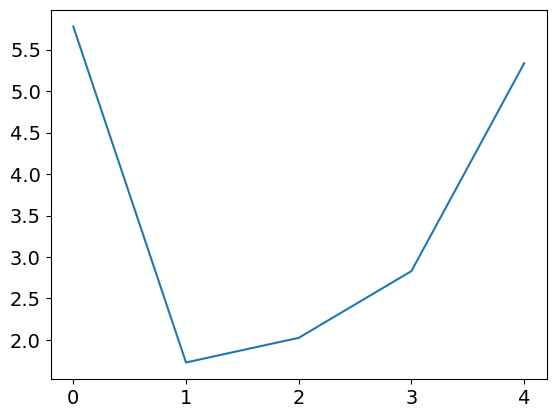

In [68]:
plt.plot(std)

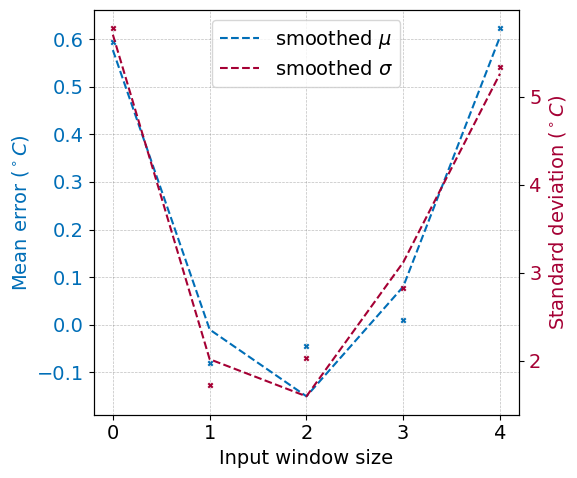

In [74]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
steps = np.arange(0, 5)
sigma = std
ax.scatter(steps, mu, s=10, color=plt_colors[0], marker="x")
# smoothed line
ax.plot(steps, savgol_filter(mu, 5, 3), color=plt_colors[0], linestyle="--", label="smoothed $\mu$")
twin_ax = ax.twinx()
twin_ax.scatter(steps, sigma, s=10, color=plt_colors[1], marker="x")
# smoothed line
twin_ax.plot(steps, savgol_filter(sigma, 5, 3), color=plt_colors[1], linestyle="--", label="smoothed $\sigma$")

# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper center")
ax.set_ylabel(r"Mean error ($^\circ C$)", color=plt_colors[0])
twin_ax.set_ylabel(r"Standard deviation ($^\circ C$)", color=plt_colors[1])
ax.tick_params(axis="y", labelcolor=plt_colors[0])
twin_ax.tick_params(axis="y", labelcolor=plt_colors[1])
ax.set_xlabel("Input window size")
ax.grid()


plt.show()

fig.savefig(f"../../report/images/chapter-4/delfi-pq-res-error-stats.pdf")



In [1]:
print(sigma)

NameError: name 'sigma' is not defined

In [275]:
print(base_models[8].predict(base_test_x.astype(np.float64)))

14/14 [==============================] - 0s 18ms/step
[[0.4897792  0.23561998 0.18506445 0.21732542 0.23224634 0.37956   ]
 [0.47900927 0.2263379  0.17134242 0.20024149 0.22372547 0.36733115]
 [0.6416523  0.49811786 0.54029864 0.6077315  0.4630817  0.624892  ]
 ...
 [0.5848867  0.6442195  0.73350227 0.6507556  0.656716   0.6542251 ]
 [0.58958095 0.65293825 0.7311008  0.6580225  0.6622398  0.66001916]
 [0.45748246 0.20815487 0.14756122 0.16936103 0.20523995 0.34389627]]


In [276]:
print(data_driven_base.model.predict(base_test_x.astype(np.float64)))

14/14 [==============================] - 0s 16ms/step
[[0.49006057 0.23310365 0.1756191  0.21821031 0.2325611  0.3836552 ]
 [0.48075044 0.21814533 0.16155355 0.20498183 0.22194828 0.37285057]
 [0.58327496 0.46555984 0.46603796 0.4288822  0.44954142 0.50783503]
 ...
 [0.606252   0.64224935 0.7116014  0.6437419  0.67774165 0.66639024]
 [0.61098015 0.6491708  0.7014024  0.6447152  0.6847368  0.66932744]
 [0.4642596  0.19114204 0.1369993  0.1778582  0.20096199 0.35306323]]


In [94]:
# Checking predictions with curve fit models
errors = []
base_preds_train = base_models[2].predict(base_train_x.astype(np.float64))
base_preds_test = base_models[2].predict(base_test_x.astype(np.float64))
for idx, res_window_size in enumerate(res_window_sizes):
    res_train_df, res_train_x, res_train_y = window_data_res(train_norm_df.reset_index(drop=True), base_preds_train, res_window_size)
    res_test_df, res_test_x, res_test_y = window_data_res(test_norm_df.reset_index(drop=True), base_preds_test, res_window_size)
    
    actual = denormalize_temperature(res_test_y, norm_limits)
    base_preds_temp = res_test_df.iloc[:, -12:-6].to_numpy()
    res_preds = res_models[idx].predict(res_test_x.astype(np.float64))
    combined_preds = res_preds
    combined_preds = denormalize_temperature(combined_preds, norm_limits)
    
    errors.append(actual - combined_preds)
    
base_test_preds = data_driven_base.model.predict(base_test_x.astype(np.float64))
actual = denormalize_temperature(data_driven_base.test_y, norm_limits)
base_test_preds = denormalize_temperature(base_test_preds, norm_limits)
    
mu = np.zeros(shape=(len(errors)+1))
std = np.zeros(shape=(len(errors)+1))

for i in range(1, 5):
    mu[i] = np.mean(errors[i-1])
    std[i] = np.std(errors[i-1])
mu[0] = np.mean(actual - base_test_preds)
std[0] = np.std(actual - base_test_preds)



14/14 [==============================] - 0s 20ms/step
Creating windowed data [========================================] 1683/1683 [100%] in 3.4s (498.65/s)                   
Creating windowed data [========================================] 421/421 [100%] in 0.7s (574.91/s)                     
6/6 [==============================] - 0s 2ms/step
Creating windowed data [========================================] 1682/1682 [100%] in 1.7s (958.51/s)                   
Creating windowed data [========================================] 420/420 [100%] in 0.3s (1499.31/s)                    
3/3 [==============================] - 0s 3ms/step
Creating windowed data [========================================] 1681/1681 [100%] in 0.9s (1638.96/s)                  
Creating windowed data [========================================] 419/419 [100%] in 0.1s (8784.72/s)                    
1/1 [==============================] - 0s 26ms/step
Creating windowed data [========================================] 

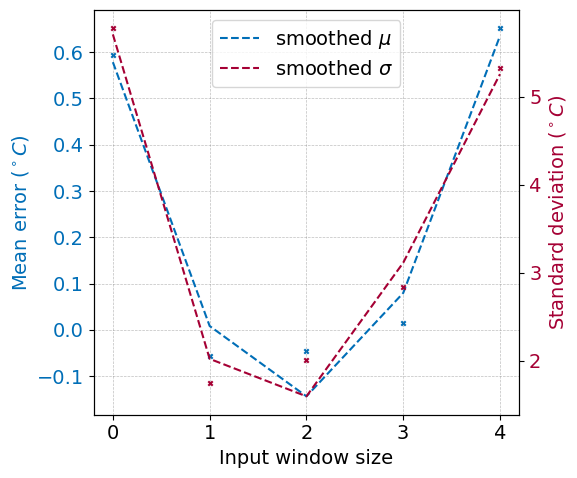

[5.77918479 1.74603376 2.0042706  2.83946156 5.32747818]


In [96]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
steps = np.arange(0, 5)
sigma = std
ax.scatter(steps, mu, s=10, color=plt_colors[0], marker="x")
# smoothed line
ax.plot(steps, savgol_filter(mu, 5, 3), color=plt_colors[0], linestyle="--", label="smoothed $\mu$")
twin_ax = ax.twinx()
twin_ax.scatter(steps, sigma, s=10, color=plt_colors[1], marker="x")
# smoothed line
twin_ax.plot(steps, savgol_filter(sigma, 5, 3), color=plt_colors[1], linestyle="--", label="smoothed $\sigma$")

# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper center")
ax.set_ylabel(r"Mean error ($^\circ C$)", color=plt_colors[0])
twin_ax.set_ylabel(r"Standard deviation ($^\circ C$)", color=plt_colors[1])
ax.tick_params(axis="y", labelcolor=plt_colors[0])
twin_ax.tick_params(axis="y", labelcolor=plt_colors[1])
ax.set_xlabel("Input window size")
ax.grid()


plt.show()

fig.savefig(f"../../report/images/chapter-5/delfi-pq-res-error-curve-fit-stats-2.pdf")
print(sigma)


In [ ]:
[5.72320061 1.648148   1.715406   3.152392   4.4474127 ]